## Load potential modules

In [4]:
#General Imports used across both Models
import sys
import os
import math
import warnings
import matplotlib
import configparser
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.legend_handler import HandlerLine2D
#from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

from ecotools.pi_client import pi_client
pi = pi_client(username = r'ad3\dlrueda')

# LSTM Specific Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
es = EarlyStopping(monitor='val_loss', patience = 3, min_delta= 0.001, mode = 'min', verbose=1)
callbacks_list= [es]

# Random Forest Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

ad3\dlrueda, please provide your password (text will be hidden) 
>>········
save password? [y/n] /n after saving, set username = 'file' to use this feature 
>>n


In [5]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import ExtraTreesRegressor

## Create functions

In [6]:
def create_standard_multivariable_df(df, point_location = 0, shift = 1, rename_OAT = True, dropna = True):
    #this function creates a standard 50 variable DataFrame
    """
    variables generated:
        - CDD: Cooling Degree Days (OAT-65), 0 where CDD < 0 
        - HDD: Heating Degree Days (65-OAT), 0 where HDD < 0
        - CDD2: (Cooling Degree Days)^2
        - HDD2: (Heating Degree Days)^2
        - MONTH (1-12): 1 on month of data point, 0 on all other months
        - TOD (0-23): 1 on "TIME OF DAY" of data point, 0 on all other times
        - DOW (0-6): 1 on "DAY OF WEEK" of data point, 0 on all other days
        - WEEKEND: 1 if data point falls on weekend, 0 for everything else
        - Shift_N: user defined shift, where N is the amount of lookback
        - Rolling24_mean: generates the rolling 24hr mean 
        - Rolling24_max: takes the maximun value of the rolling 24hr
        - Rolling 24_min: takes the minimum value of the rolling 24hr
    """
    
    if rename_OAT:
        df.rename(columns={'aiTIT4045':'OAT'}, inplace=True)
    #start_col = len(df.columns)
    df["CDD"] = df.OAT - 65.0
    df.loc[df.CDD < 0 , "CDD"] = 0.0
    df["HDD"] = 65.0 - df.OAT
    df.loc[df.HDD < 0, "HDD" ] = 0.0
    df["CDD2"] = df.CDD ** 2
    df["HDD2"] = df.HDD ** 2
    df.OAT = df.OAT.round(0)
    df.CDD = df.CDD.round(0)
    df.HDD = df.HDD.round(0)
    df.CDD2 = df.CDD2.round(0)
    df.HDD2 = df.HDD2.round(0)
    
    month = [str("MONTH_" + str(x+1)) for x in range(12)]
    df["MONTH"] = df.index.month
    df.MONTH = df.MONTH.astype('category')
    month_df = pd.get_dummies(data = df, columns = ["MONTH"])
    month_df = month_df.T.reindex(month).T.fillna(0)
    month_df = month_df.drop(month_df.columns[0], axis = 1)

    tod = [str("TOD_" + str(x)) for x in range(24)]
    df["TOD"] = df.index.hour
    df.TOD = df.TOD.astype('category')
    tod_df = pd.get_dummies(data = df, columns = ["TOD"])
    tod_df = tod_df.T.reindex(tod).T.fillna(0)
    tod_df = tod_df.drop(tod_df.columns[0], axis = 1)

    dow = [str('DOW_' + str(x)) for x in range(7)]
    df["DOW"] = df.index.weekday
    df.DOW = df.DOW.astype('category')
    dow_df = pd.get_dummies(data = df, columns = ["DOW"])
    dow_df = dow_df.T.reindex(dow).T.fillna(0)
    dow_df = dow_df.drop(dow_df.columns[0], axis = 1)

    df["WEEKEND"] = 0
    df.loc[(dow_df.DOW_5 == 1) | (dow_df.DOW_6 == 1), 'WEEKEND'] = 1

    for i in range(shift):
        shift_col = "SHIFT_" + str(i+1)
        df[shift_col] = df.iloc[ : , point_location].shift(i+1)

    # df["Rolling24_mean"] = df.iloc[ : , point_location].rolling("24h").mean()
    # df["Rolling24_max"] = df.iloc[ : , point_location].rolling("24h").max()
    # df["Rolling24_min"] = df.iloc[ : , point_location].rolling("24h").min()

    df = pd.concat([df, month_df, tod_df, dow_df], axis = 1)
    df.drop(['MONTH', 'TOD', 'DOW'], axis = 1, inplace = True)
    if dropna:
        df.dropna(inplace = True)

    del month_df
    del tod_df
    del dow_df
    #print(f'Generated: {len(df.columns) - start_col} columns')
    return df

In [7]:
def model_split_data(X, y, training_percent=0.7, scale = True):
    train_idx = X[ : int(training_percent * len(X))].index
    test_idx = X[int(training_percent * len(X)):].index
    if scale:
        scaler = MinMaxScaler(feature_range=(0,1))
        X = scaler.fit_transform(X)
        y = scaler.fit_transform(np.array(y).reshape((-1,1)))

    X_train, X_test = np.split(X, [int(training_percent * len(X))])
    y_train, y_test = np.split(y, [int(training_percent * len(y))])
    if scale:
        return X_train, X_test, y_train, y_test, scaler, train_idx, test_idx
    else:
        return X_train, X_test, y_train, y_test, train_idx, test_idx

In [8]:
def generate_actual_vs_model_df(model, X, y, scaler, trend, seasonal, index, train_on_residuals = True, use_scaler = True):
    prediction = model.predict(X)
    if use_scaler:
        prediction = scaler.inverse_transform(prediction.reshape(-1,1)).reshape((-1,))
        actual = scaler.inverse_transform(y).reshape((-1,))
    else:
        prediction = np.reshape(prediction,(-1,))
        actual = np.reshape(y, (-1,))
    if train_on_residuals:    
        prediction = prediction + trend + seasonal
        actual = actual + trend + seasonal
    r2 = r2_score(y_true=actual, y_pred=prediction)
    rmse = math.sqrt(mean_squared_error(actual, prediction))
    cvrmse = rmse / np.mean(prediction)
    mae = np.median(actual - prediction)
    result_df = pd.DataFrame({"Actual" : actual, "Modeled" : prediction}, index = index)
    return result_df, r2, rmse, cvrmse, mae

In [9]:
# extra trees regressor with halving random search
def create_etr_model_hrs(df1, X, y, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df)

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])

    # Hyperparameter grid
    #param_grid = {'criterion':['squared_error', 'absolute_error'],  'n_estimators':np.linspace(10, 200).astype(int), 
    #              'random_state':[1], 'min_samples_split': [2, 5, 10],'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 
    #              'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)), 'bootstrap' : [True,False], 
    #              'n_jobs' : [-1]}    
    
    # Hyperparameter grid
    param_grid = {'criterion':['squared_error', 'absolute_error'],                              
                  'n_estimators':[10,100,200], 'random_state':[42], 'min_samples_split': [2, 5, 10],
                 'max_depth': [10], 'max_leaf_nodes': [10,100,200]}

    # Estimator for use in random search
    estimator = ExtraTreesRegressor()


    # Create the random search model
    halving_cv = HalvingRandomSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, n_candidates=10, factor=3, cv = 4)

    # Fit 
    halving_cv.fit(X_train, y_train)
    
    
    
    model = ExtraTreesRegressor(n_estimators = halving_cv.best_params_['n_estimators'], 
                               max_depth = halving_cv.best_params_['max_depth'],
                               max_leaf_nodes = halving_cv.best_params_['max_leaf_nodes'],
                               min_samples_split = halving_cv.best_params_['min_samples_split'],
                               random_state = halving_cv.best_params_['random_state'],
                               criterion = halving_cv.best_params_['criterion'])
    
    
    # fit model
    model = model.fit(X_train, y_train)


#         if kwargs['show_training_plot']:
#             plot_model_training(train, val, epochs, neurons, show_every = show_every)

    #model = history.model

    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
                                                                                          X_train, y_train, scaler, 
                                                                                          trend = None, seasonal = None, index = train_idx, train_on_residuals = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)

    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
                                                                                     X_test, y_test, scaler, 
                                                                                     trend = None, seasonal = None, index = test_idx, train_on_residuals = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3) 

    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"                
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return halving_cv.best_params_

In [10]:
# random forest regressor with halving random search
def create_rfr_model_hrs(df1, X, y, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df)

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])

    # Hyperparameter grid
    #param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01, 0.001, 0.05],                               
    #              'n_estimators':np.linspace(10, 200).astype(int), 'random_state':[42], 'min_samples_split': [2, 5, 10],
    #             'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int))}
    
    
    # Hyperparameter grid
    param_grid = {'criterion':['squared_error', 'absolute_error'], 'n_estimators':[100], 'random_state':[42], 
                  'min_samples_split': [2, 5, 10], 'max_depth': [10], 'max_leaf_nodes': [10,100,200]}

    # Estimator for use in random search
    estimator = RandomForestRegressor()


    # Create the random search model
    halving_cv = HalvingRandomSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, n_candidates=10, factor=5, cv = 5)
    #halving_cv = TuneSearchCV(estimator, param_grid, n_trials=3)
    
    # Fit 
    halving_cv.fit(X_train, y_train)
    
    
    model = RandomForestRegressor(n_estimators = halving_cv.best_params_['n_estimators'],
                               max_depth = halving_cv.best_params_['max_depth'],
                               max_leaf_nodes = halving_cv.best_params_['max_leaf_nodes'],
                               min_samples_split = halving_cv.best_params_['min_samples_split'],
                               random_state = halving_cv.best_params_['random_state'],
                               criterion = halving_cv.best_params_['criterion'])
    
    
    # fit model
    model = model.fit(X_train, y_train)


#         if kwargs['show_training_plot']:
#             plot_model_training(train, val, epochs, neurons, show_every = show_every)

    #model = history.model

    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
                                                                                          X_train, y_train, scaler, 
                                                                                          trend = None, seasonal = None, index = train_idx, train_on_residuals = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)

    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
                                                                                     X_test, y_test, scaler, 
                                                                                     trend = None, seasonal = None, index = test_idx, train_on_residuals = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3) 

    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"                
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return halving_cv.best_params_

In [11]:
# gradient boosting regressor with halving random search
def create_gbr_model_hrs(df1, X, y, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df)

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])

    # Hyperparameter grid
    #param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01, 0.001, 0.05],                               
    #              'n_estimators':np.linspace(10, 200).astype(int), 'random_state':[42], 'min_samples_split': [2, 5, 10],
    #             'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int))}
    
    
    # Hyperparameter grid
    param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01],                               
                  'n_estimators':[100,200,500], 'random_state':[42], 'min_samples_split': [2, 5, 10],
                 'max_depth': [10], 'max_leaf_nodes': [10,100]}

    # Estimator for use in random search
    estimator = GradientBoostingRegressor()


    # Create the random search model
    halving_cv = HalvingRandomSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, n_candidates=10, factor=5, cv = 4)
    #halving_cv = TuneSearchCV(estimator, param_grid, n_trials=3)
    
    # Fit 
    halving_cv.fit(X_train, y_train)
    
    
    model = GradientBoostingRegressor(n_estimators = halving_cv.best_params_['n_estimators'], 
                               loss = halving_cv.best_params_['loss'],
                               max_depth = halving_cv.best_params_['max_depth'],
                               max_leaf_nodes = halving_cv.best_params_['max_leaf_nodes'],
                               min_samples_split = halving_cv.best_params_['min_samples_split'],
                               random_state = halving_cv.best_params_['random_state'],
                               learning_rate = halving_cv.best_params_['learning_rate'],
                               criterion = halving_cv.best_params_['criterion'])
    
    
    # fit model
    model = model.fit(X_train, y_train)


#         if kwargs['show_training_plot']:
#             plot_model_training(train, val, epochs, neurons, show_every = show_every)

    #model = history.model

    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
                                                                                          X_train, y_train, scaler, 
                                                                                          trend = None, seasonal = None, index = train_idx, train_on_residuals = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)

    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
                                                                                     X_test, y_test, scaler, 
                                                                                     trend = None, seasonal = None, index = test_idx, train_on_residuals = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3) 

    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"                
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return halving_cv.best_params_

In [12]:
def create_model(df1, X, y, mod, mod_inputs, point_location=0):
    df = df1.copy()
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)
#     df = create_standard_multivariable_df(df) 

    X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent']) 

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_train = np.nan_to_num(X_train)
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    train = pd.DataFrame()
    val = pd.DataFrame()
    np.random.seed(mod_inputs['random_seed'])
    

    X_train, X_test, y_train, y_test,  train_idx, test_idx = model_split_data(X,y, mod_inputs['training_percent'], scale = False)
    
    mod = mod
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    X_train.fillna(method = 'ffill', inplace = True)
    X_train.fillna(method ='bfill', inplace = True)
    y_train.fillna(method = 'ffill', inplace = True)
    y_train.fillna(method ='bfill', inplace = True)


    model = mod.fit(X_train.fillna(method='ffill'), y_train.fillna(method='ffill'))


    train_df, train_r2, train_rmse, train_cvrmse, train_mae = generate_actual_vs_model_df(model, 
            X_train, y_train, scaler = None, 
            trend = None, seasonal = None, index = train_idx, train_on_residuals = False, use_scaler = False)
    train_r2 = round(train_r2, 3)
    train_rmse = round(train_rmse, 3)
    train_cvrmse = round(train_cvrmse, 3)
    train_mae = round(train_mae, 3)
    
    test_df, test_r2, test_rmse, test_cvrmse, test_mae = generate_actual_vs_model_df(model, 
            X_test, y_test, scaler = None, 
            trend = None, seasonal = None, index = test_idx, train_on_residuals = False, use_scaler = False)
    test_r2 = round(test_r2, 3)
    test_rmse = round(test_rmse, 3)
    test_cvrmse = round(test_cvrmse, 3)
    test_mae = round(test_mae, 3)

    print(f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae}")
    print(f"Test: Actual vs. Modeled \n R2: {test_r2}  RMSE: {test_rmse}  CVRMSE: {test_cvrmse}  MAE: {test_mae}")
    
    plt.style.use('fivethirtyeight')
    figure(num=None, figsize=(18,5), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot()
    ax.plot(train_df.Actual, label = 'Training', linewidth = 1, color = 'black')
    ax.plot(train_df.Modeled, label = 'Training - Modeled', linewidth = 1, color = 'green', alpha=0.5)
    ax.plot(test_df.Actual, label = 'Test', linewidth = 1, color = 'black')
    ax.plot(test_df.Modeled, label = 'Test - Modeled', linewidth = 1, color = 'blue', alpha=0.5)
    plt.legend(prop={'size': 14})
    train_title = f"Training: Actual vs. Modeled \n R2: {train_r2}  RMSE: {train_rmse}  CVRMSE: {train_cvrmse}  MAE: {train_mae} \n R2 Test: {test_r2}  RMSE Test: {test_rmse}  CVRMSE Test: {test_cvrmse}  MAE Test: {test_mae}"            
    plt.title(train_title, fontsize = 14)
    plt.show()
    
    return df

# --------------- with cleaning

In [13]:
def clean_data(df, tag):
    df_out = df[[tag]].copy()
    
    IQR = df_out.quantile(0.75) - df_out.quantile(0.25)
    df_final = df_out[~((df_out < (df_out.quantile(0.25) - 3 * IQR)) | (df_out > (df_out.quantile(0.75) + 3 * IQR)))]

    df_final.dropna(axis=0, inplace=True)

    df_final.reset_index(inplace=True)
    df = df.loc[df_final['Timestamp']]
    df.reset_index(inplace = True)
    df.set_index('Timestamp', inplace = True)
    
    return df

# Run model

In [14]:
import timeit

# 1.  'Ghausi_Electricity_Demand_kBtu' w/o EPS

In [15]:
tags = ['Ghausi_Electricity_Demand_kBtu', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [16]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

09:16:57: Sending API request... Chunk 1 of 1
09:16:59: Response recieved for 2 tags! (1.98)


In [17]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [18]:
data3 = clean_data(data2, 'Ghausi_Electricity_Demand_kBtu')

In [19]:
y = data3.iloc[:,0]
X = data3.iloc[:,2:]

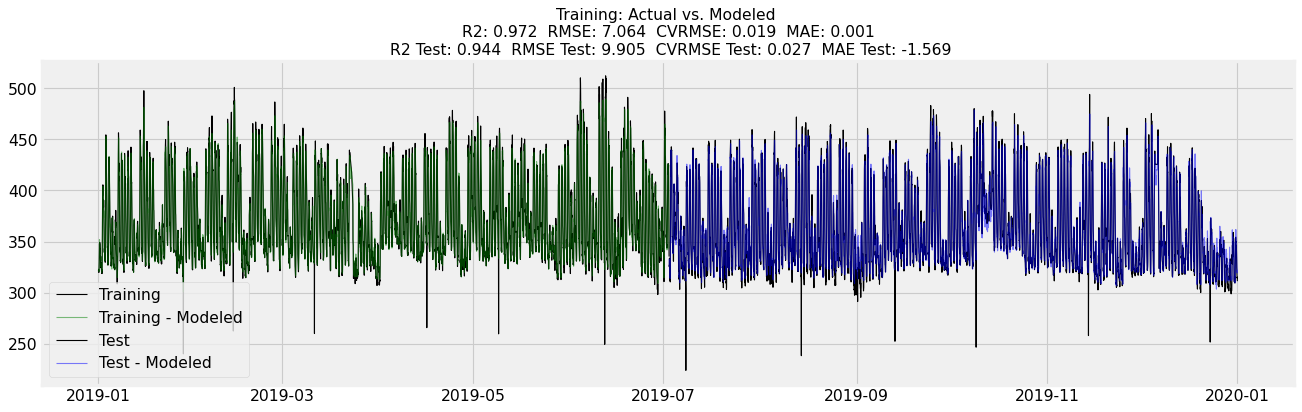

50.3692093249997 seconds


In [22]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [20]:
import stopit

In [23]:
with stopit.ThreadingTimeout(5) as context_manager:
     
    # sample code we want to run...
    gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
        
# Did code timed out
if context_manager.state == context_manager.TIMED_OUT:
    print("INCOMPLETE...")



INCOMPLETE...


In [18]:
import multiprocessing
import time

In [1]:
import time
from itertools import count
from multiprocessing import Process

def inc_forever():
    print('Starting function inc_forever()...')
    while True:
        time.sleep(1)
        print(next(counter))
def return_zero():
    print('Starting function return_zero()...')
    return 0
        

In [10]:
if __name__ == '__main__':
    # counter is an infinite iterator
    counter = count(0)
    p1 = Process(target=inc_forever, name='Process_inc_forever')
    p2 = Process(target=return_zero, name='Process_return_zero')
    p1.start()
    p2.start()
    p1.join(timeout=5)
    p2.join(timeout=5)
    p1.terminate()
    p2.terminate()
if p1.exitcode is None:
       print(f'Oops, {p1} timeouts!')
if p2.exitcode == 0:
        print(f'{p2} is luck and finishes in 5 seconds!')

In [21]:
from threading import Thread, Event
import time
 
# Event object used to send signals from one thread to another
stop_event = Event()

 
def do_actions():
    """
    Function that should timeout after 5 seconds. It simply prints a number and waits 1 second.
    :return:
    """
    i = 0
    while True:
        i += 1
        print(i)
        time.sleep(1)
 
        # Here we make the check if the other thread sent a signal to stop execution.
        if stop_event.is_set():
            break
 
 
if __name__ == '__main__':
    # We create another Thread
    action_thread = Thread(target=do_actions)
 
    # Here we start the thread and we wait 5 seconds before the code continues to execute.
    action_thread.start()
    action_thread.join(timeout=5)
 
    # We send a signal that the other thread should stop.
    stop_event.set()
 
    print("Hey there! I timed out! You can do things after me!")

1
2
3
4
5
Hey there! I timed out! You can do things after me!


In [13]:
def do_actions():
    """
    Function that should timeout after 5 seconds. It simply prints a number and waits 1 second.
    :return:
    """
    i = 0
    while True:
        i += 1
        print(i)
        time.sleep(1)

In [14]:
if __name__ == '__main__':
    # We create a Process
    action_process = Process(target=do_actions)
 
    # We start the process and we block for 5 seconds.
    action_process.start()
    action_process.join(timeout=5)
 
    # We terminate the process.
    action_process.terminate()
    print("Hey there! I timed out! You can do things after me!")

Hey there! I timed out! You can do things after me!


In [19]:
import multiprocessing
import time

def foo(n):
    for i in range(10000 * n):
        print(i)
        time.sleep(1)

In [20]:
#import multiprocessing
#import time

#def foo(n):
#    for i in range(10000 * n):
#        print(i)
#        time.sleep(1)

if __name__ == '__main__':
    # Start foo as a process
    p = multiprocessing.Process(target=foo, name="Foo", args=(10,))
    p.start()

    # Wait 10 seconds for foo
    time.sleep(10)

    # Terminate foo
    p.terminate()

    # Cleanup
    p.join()

In [22]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

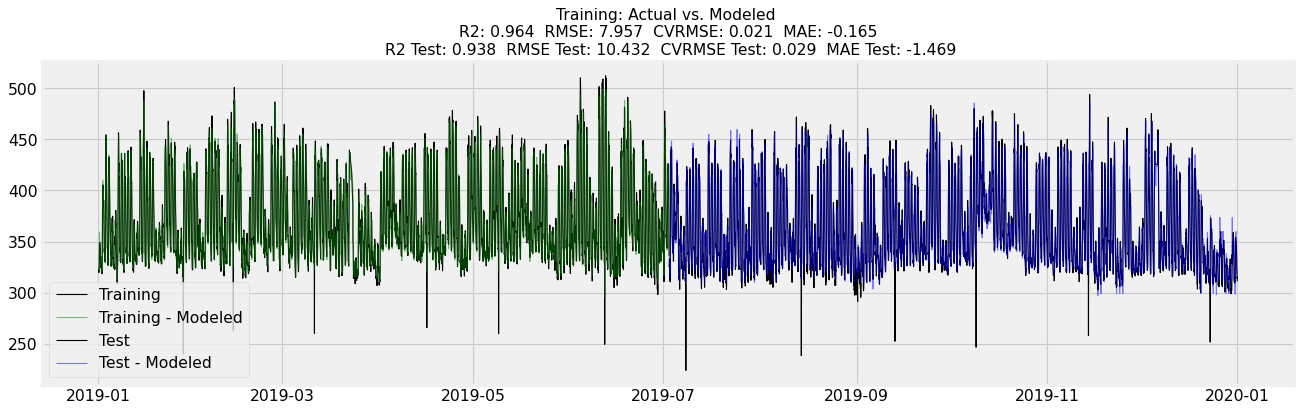

7.4708847160000005 seconds


In [179]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [175]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [25]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [70]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


KeyboardInterrupt: 

In [29]:
etr

{'random_state': 42,
 'n_estimators': 10,
 'min_samples_split': 2,
 'max_leaf_nodes': 200,
 'max_depth': 50,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.971  RMSE: 7.131  CVRMSE: 0.019  MAE: -0.109
Test: Actual vs. Modeled 
 R2: 0.942  RMSE: 10.131  CVRMSE: 0.028  MAE: -2.193


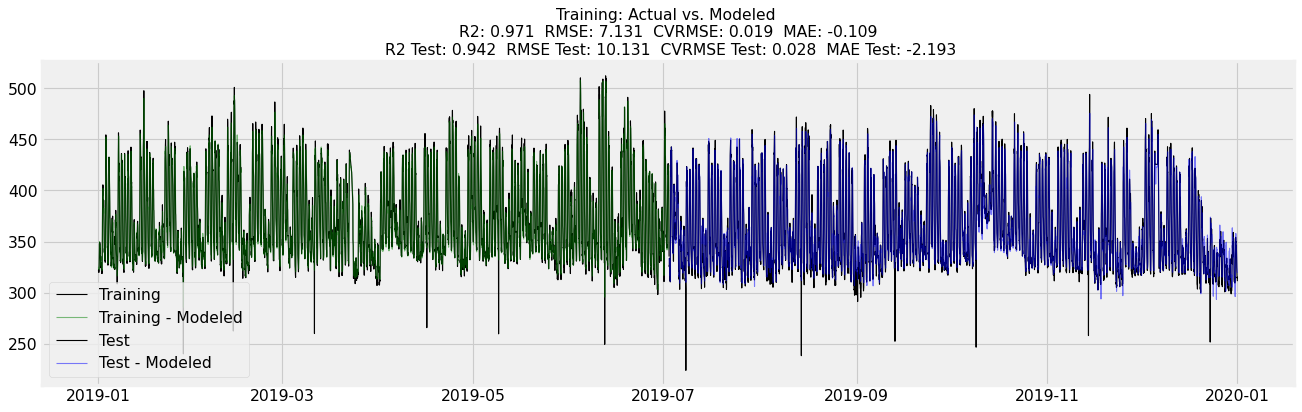

1.4080469040000025 seconds


In [30]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.974  RMSE: 6.777  CVRMSE: 0.018  MAE: -0.07
Test: Actual vs. Modeled 
 R2: 0.938  RMSE: 10.432  CVRMSE: 0.029  MAE: -1.402


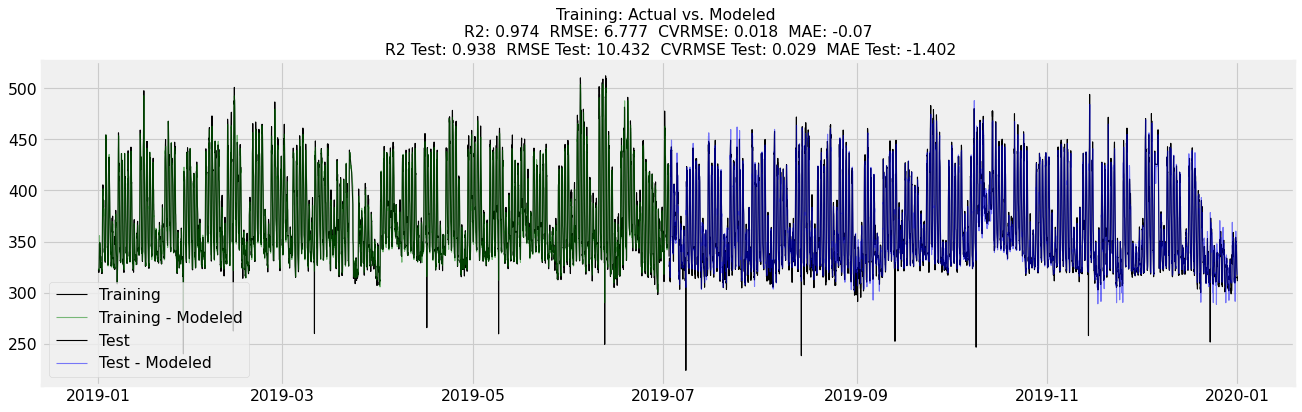

2.0177355299999817 seconds


In [32]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


# 2.  EPS w/o 'Ghausi_Electricity_Demand_kBtu'

In [255]:
tags = ['EPS.AHU.AHU01.RMAVG.Zone Air Temp', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [256]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
data.head()

19:44:08: Sending API request... Chunk 1 of 1
19:44:10: Response recieved for 2 tags! (2.16)


EPS.AHU.AHU01.RMAVG.Zone Air Temp  aiTIT4045
Timestamp                                                        
2019-01-01 00:00:00                          71.674997  41.556886
2019-01-01 01:00:00                          71.674999  41.994667
2019-01-01 02:00:00                          71.612512  40.879091
2019-01-01 03:00:00                          71.712485  41.991956
2019-01-01 04:00:00                          71.599999  41.944634

In [257]:
data2 = create_standard_multivariable_df(data)
data2.head()

EPS.AHU.AHU01.RMAVG.Zone Air Temp   OAT  CDD   HDD  CDD2  \
Timestamp                                                                       
2019-01-01 01:00:00                          71.674999  42.0  0.0  23.0   0.0   
2019-01-01 02:00:00                          71.612512  41.0  0.0  24.0   0.0   
2019-01-01 03:00:00                          71.712485  42.0  0.0  23.0   0.0   
2019-01-01 04:00:00                          71.599999  42.0  0.0  23.0   0.0   
2019-01-01 05:00:00                          71.687511  42.0  0.0  23.0   0.0   

                      HDD2  WEEKEND    SHIFT_1  MONTH_2  MONTH_3  ...  TOD_20  \
Timestamp                                                         ...           
2019-01-01 01:00:00  529.0        0  71.674997      0.0      0.0  ...     0.0   
2019-01-01 02:00:00  582.0        0  71.674999      0.0      0.0  ...     0.0   
2019-01-01 03:00:00  529.0        0  71.612512      0.0      0.0  ...     0.0   
2019-01-01 04:00:00  532.0        0  71.712485      0.0      0.0  ...     0.0   
2019-01-01 05:00:00  524.0        0  71.599999      0.0      0.0  ...     0.0   

                     TOD_21  TOD_22  TOD_23  DOW_1  DOW_2  DOW_3  DOW_4  \
Timestamp                                                                 
2019-01-01 01:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 02:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 03:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 04:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   
2019-01-01 05:00:00     0.0     0.0     0.0    1.0    0.0    0.0    0.0   

                     DOW_5  DOW_6  
Timestamp                          
2019-01-01 01:00:00    0.0    0.0  
2019-01-01 02:00:00    0.0    0.0  
2019-01-01 03:00:00    0.0    0.0  
2019-01-01 04:00:00    0.0    0.0  
2019-01-01 05:00:00    0.0    0.0  

[5 rows x 48 columns]

In [258]:
data3 = clean_data(data2, 'EPS.AHU.AHU01.RMAVG.Zone Air Temp')

In [259]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

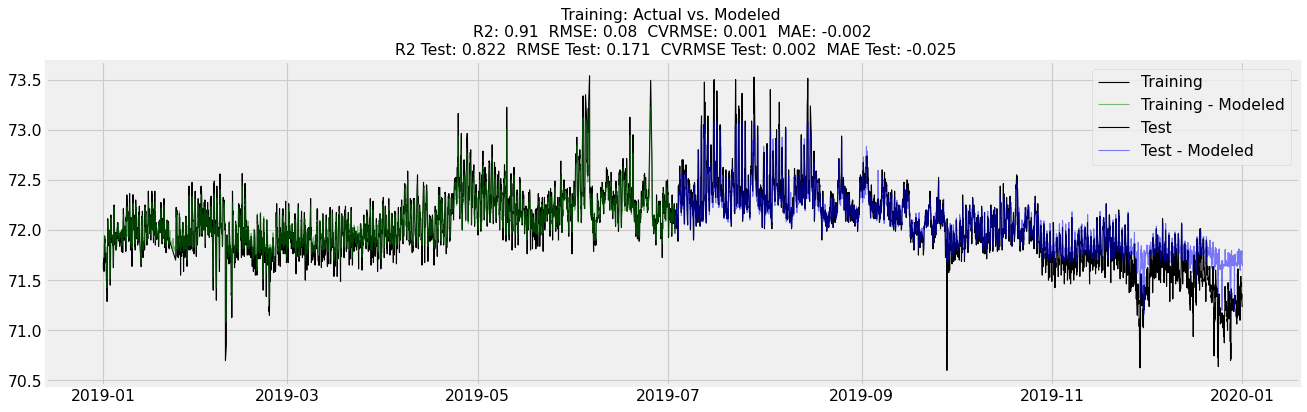

9.448209361999034 seconds


In [260]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [186]:
gbr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

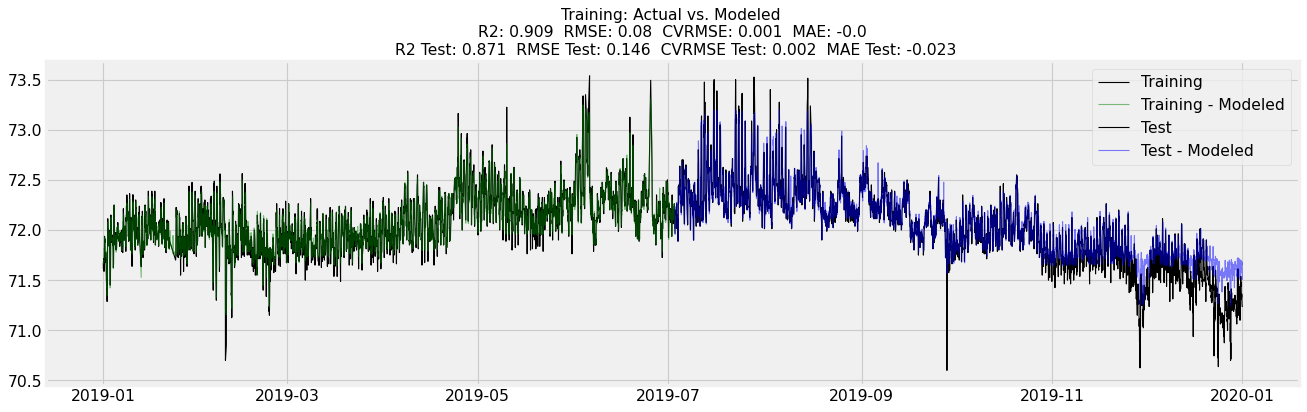

6.33280096999988 seconds


In [188]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [42]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

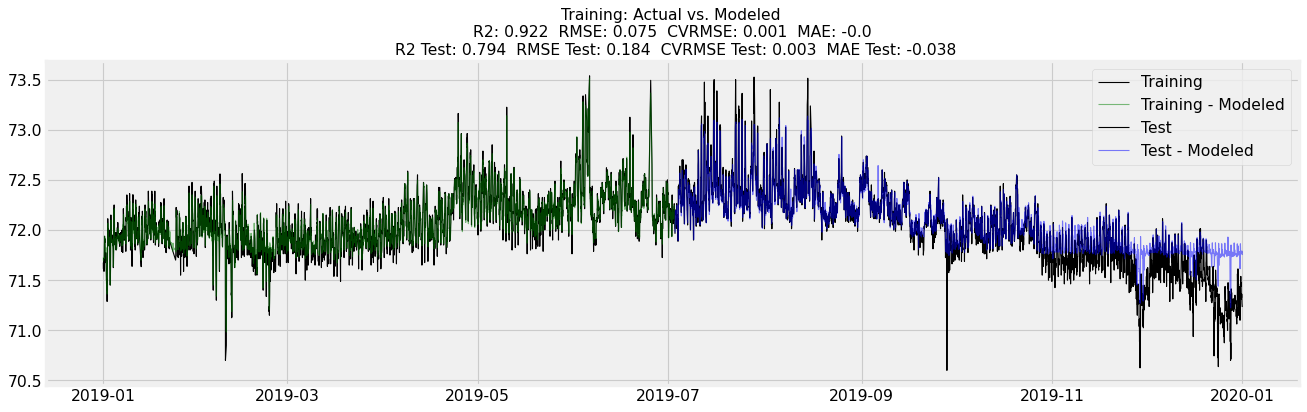

7.304548209999666 seconds


In [78]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [45]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.929  RMSE: 0.071  CVRMSE: 0.001  MAE: 0.0
Test: Actual vs. Modeled 
 R2: 0.787  RMSE: 0.187  CVRMSE: 0.003  MAE: -0.04


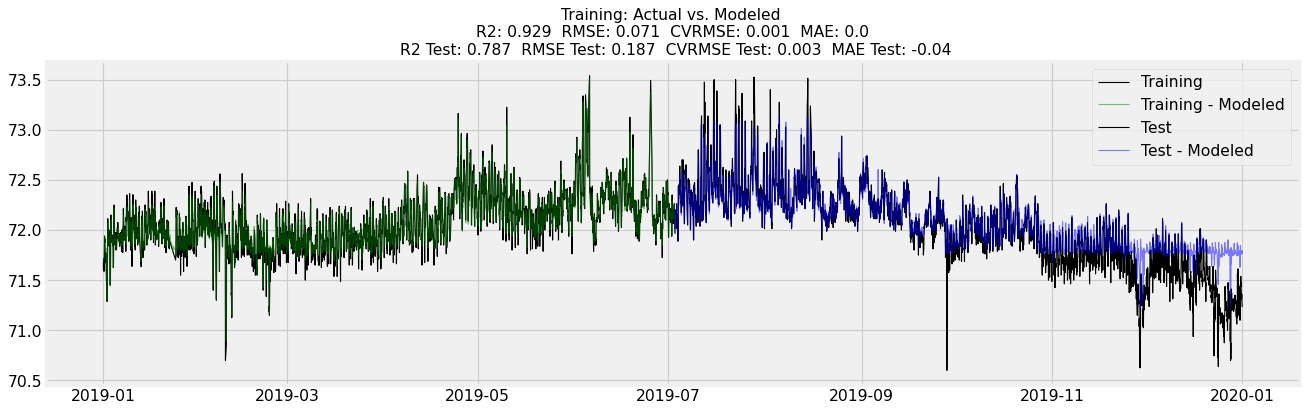

1.2931954749997203 seconds


In [47]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.932  RMSE: 0.069  CVRMSE: 0.001  MAE: 0.001
Test: Actual vs. Modeled 
 R2: 0.863  RMSE: 0.15  CVRMSE: 0.002  MAE: -0.024


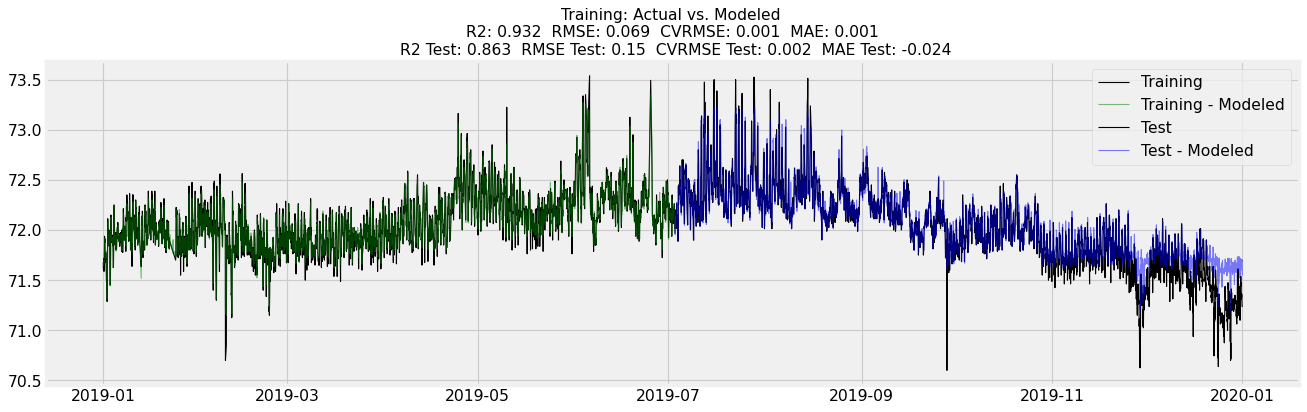

1.7129969040001924 seconds


In [48]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


# Other tags

In [32]:
#'ACAD.AHU.AHU01.Supply Air Temp',
#'ACAD.AHU.AHU0.Supply Air Temp',
#'BJ1.AHU.AC07.Supply Air Temp',
#'BJ1.AHU.AC08.Supply Air Temp',
#'ACAD.AHU.AHU01.Supply Air Temp Setpoint',
#'ACAD.AHU.AHU01.Supply Air Temp Setpoint',
#'CHEMX.AHU.SF1N.Heating Valve Control Output',
#'CHEMX.AHU.SF1S.Heating Valve Control Output'

## 'ACAD.AHU.AHU01.Supply Air Temp'

In [261]:
tags = ['ACAD.AHU.AHU01.Supply Air Temp', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [262]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:47:41: Sending API request... Chunk 1 of 1
19:47:43: Response recieved for 2 tags! (1.88)


In [263]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [264]:
data3 = clean_data(data2, 'ACAD.AHU.AHU01.Supply Air Temp')

In [265]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

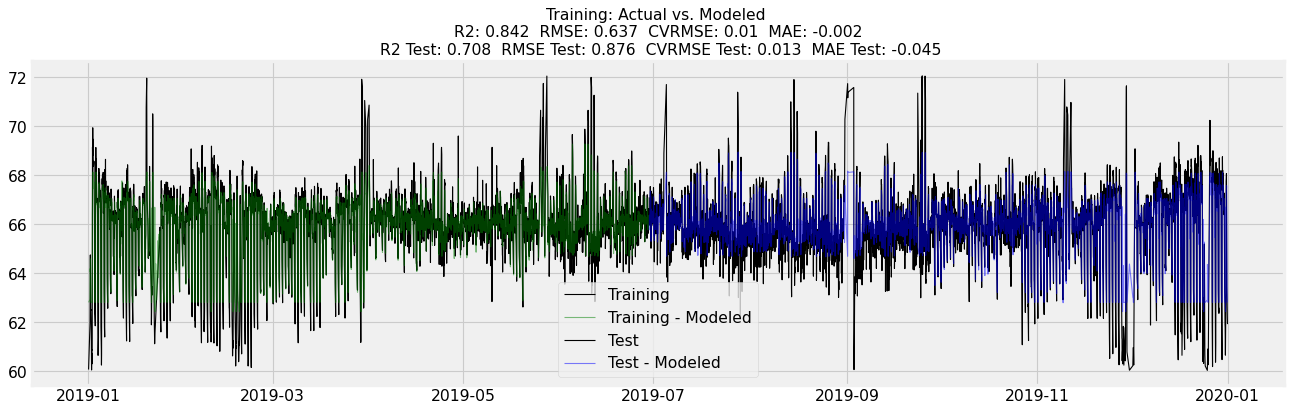

21.27783554800044 seconds


In [266]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [85]:
gbr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'lad',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

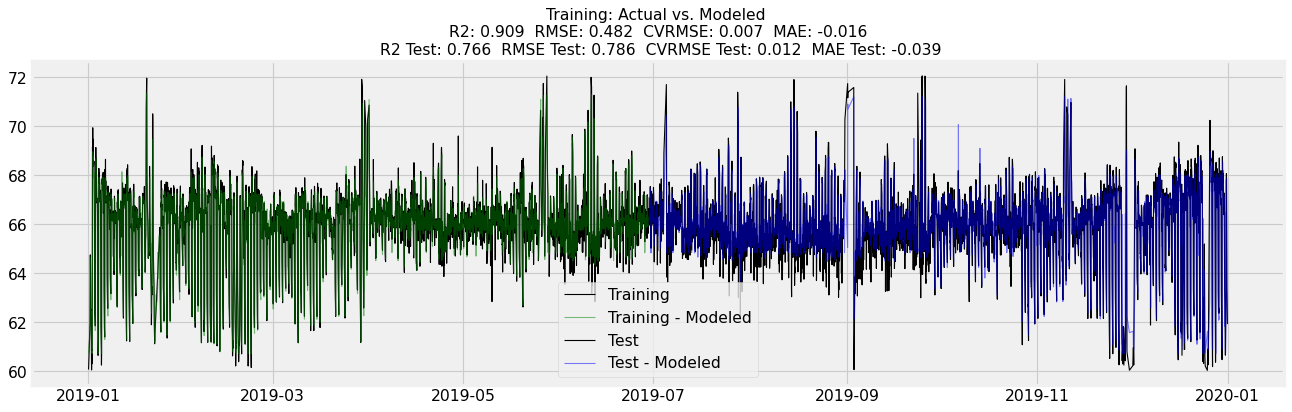

7.032387343999289 seconds


In [194]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [54]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

In [87]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


KeyboardInterrupt: 

In [212]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.923  RMSE: 0.445  CVRMSE: 0.007  MAE: -0.008
Test: Actual vs. Modeled 
 R2: 0.769  RMSE: 0.78  CVRMSE: 0.012  MAE: -0.039


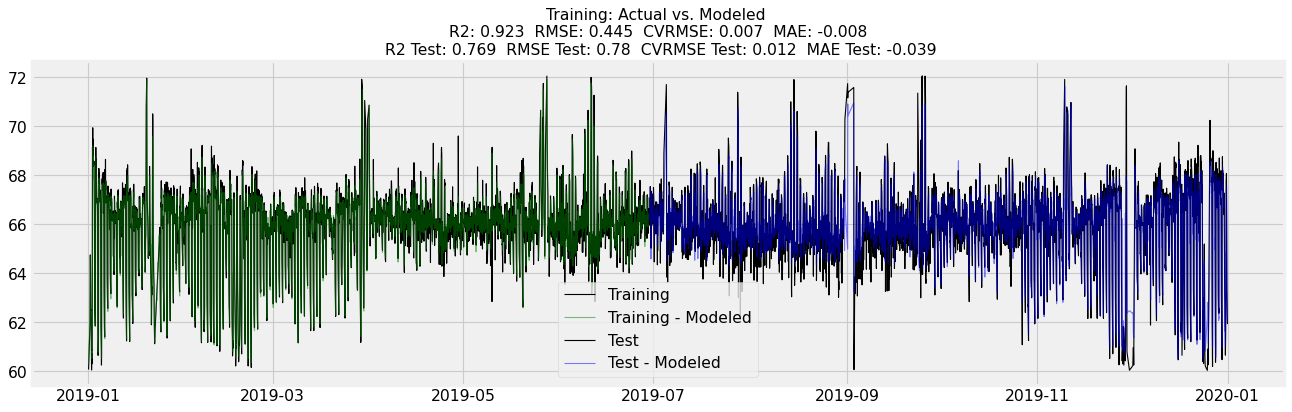

1.5695724980005252 seconds


In [90]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training: Actual vs. Modeled 
 R2: 0.927  RMSE: 0.432  CVRMSE: 0.007  MAE: -0.007
Test: Actual vs. Modeled 
 R2: 0.764  RMSE: 0.789  CVRMSE: 0.012  MAE: -0.044


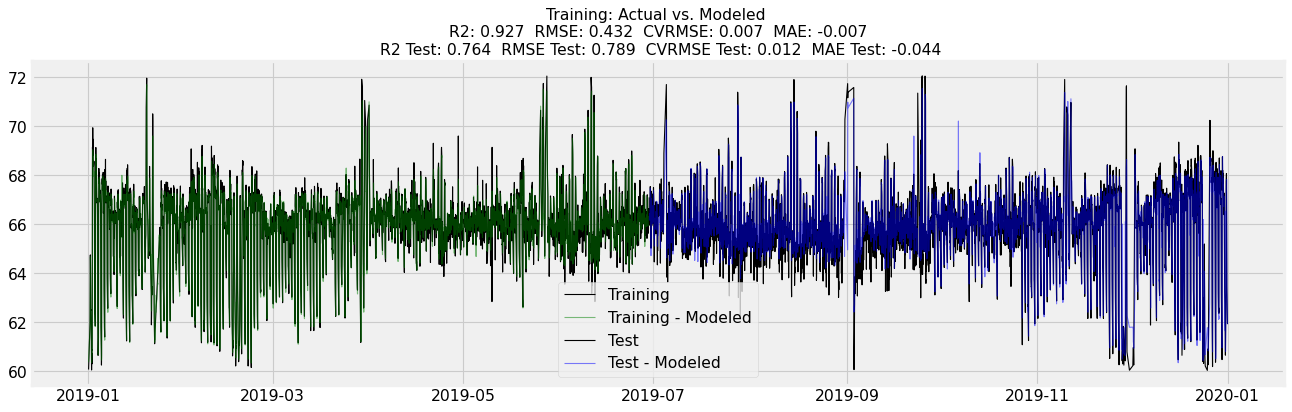

2.4852641299994502 seconds


In [91]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'ACAD.AHU.AHU02.Supply Air Temp'

In [195]:
tags = ['ACAD.AHU.AHU02.Supply Air Temp', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [196]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:21:33: Sending API request... Chunk 1 of 1
19:21:35: Response recieved for 2 tags! (1.91)


In [197]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [198]:
data3 = clean_data(data2, 'ACAD.AHU.AHU02.Supply Air Temp')

In [199]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

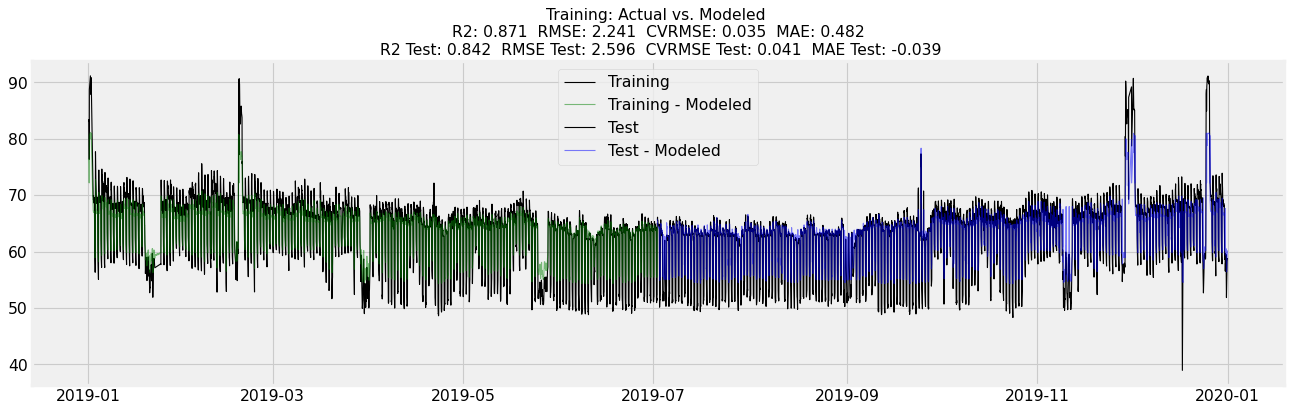

3.949948995000341 seconds


In [97]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [65]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

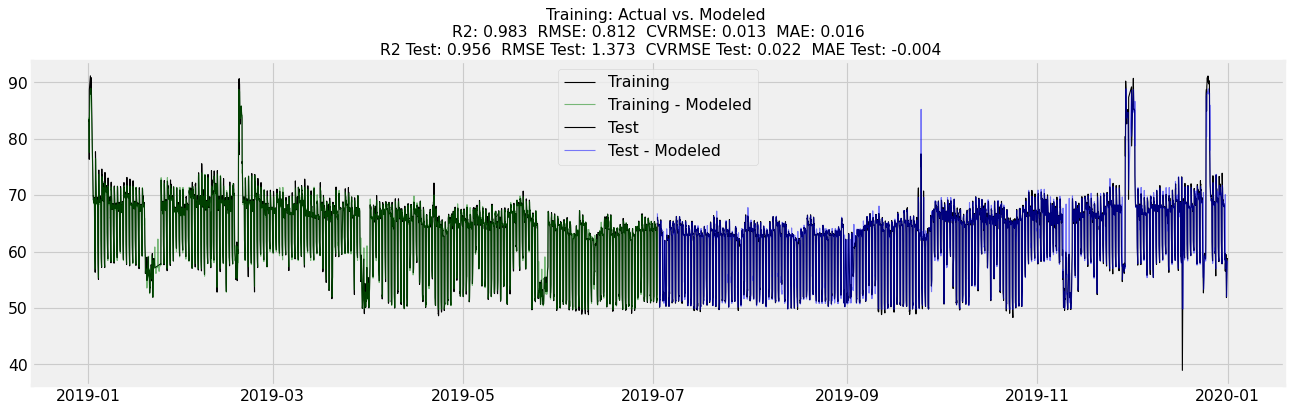

6.384736369000166 seconds


In [200]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [184]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

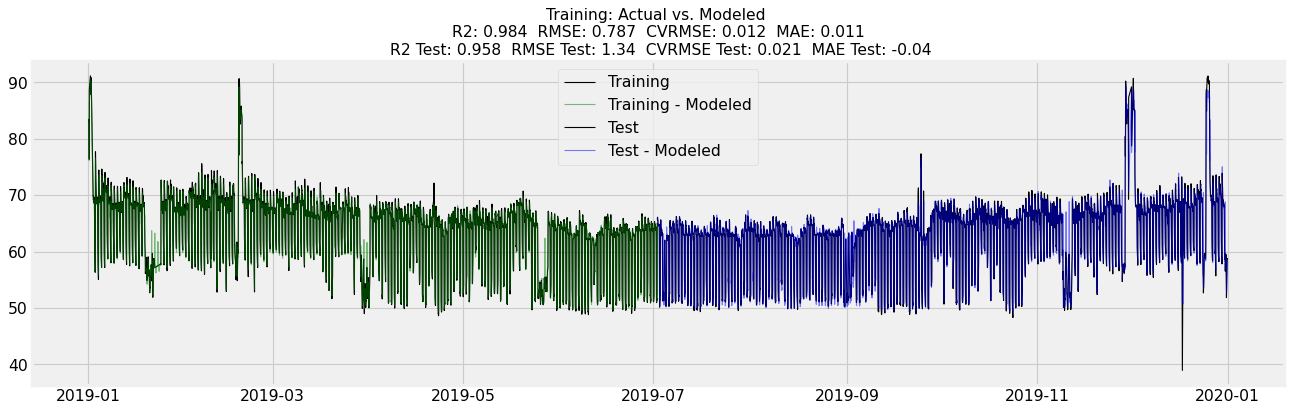

7.63739041899953 seconds


In [99]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [69]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.985  RMSE: 0.756  CVRMSE: 0.012  MAE: 0.008
Test: Actual vs. Modeled 
 R2: 0.957  RMSE: 1.354  CVRMSE: 0.022  MAE: -0.066


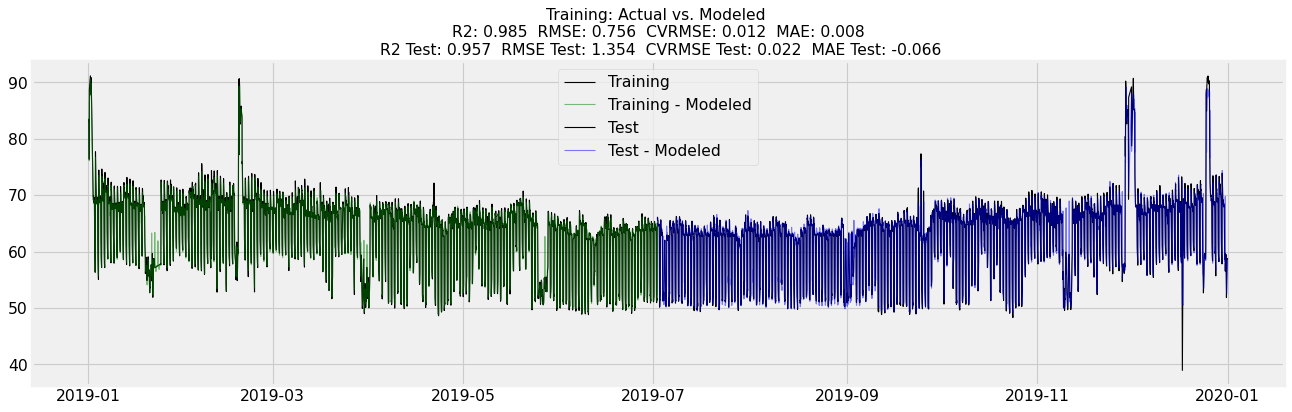

1.3464877820006222 seconds


In [100]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.989  RMSE: 0.656  CVRMSE: 0.01  MAE: -0.002
Test: Actual vs. Modeled 
 R2: 0.957  RMSE: 1.357  CVRMSE: 0.022  MAE: -0.007


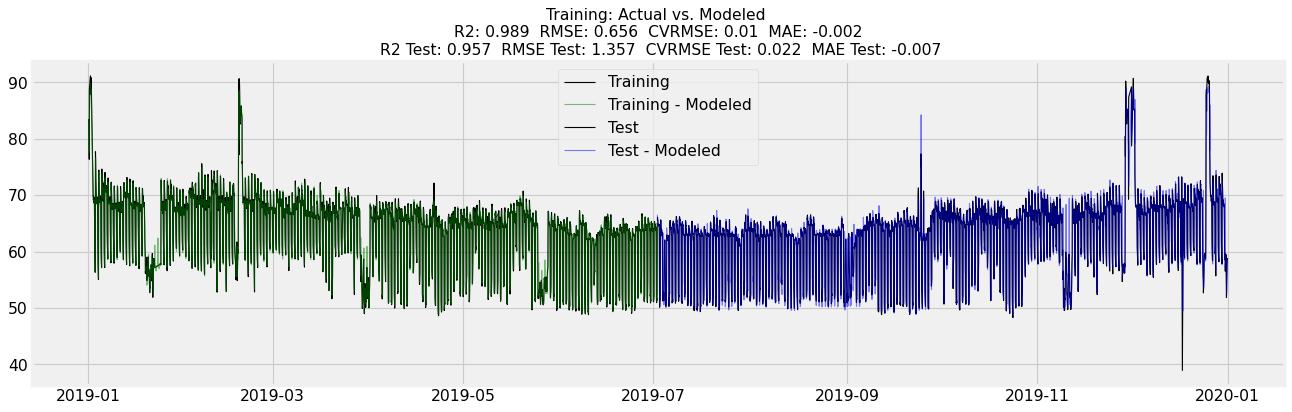

1.8691118569995524 seconds


In [101]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'BJ1.AHU.AC07.Supply Air Temp'

In [201]:
tags = ['BJ1.AHU.AC07.Supply Air Temp', 'aiTIT4045']
start = '2020-01-01'
end = '2021-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [202]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:22:47: Sending API request... Chunk 1 of 1
19:22:48: Response recieved for 2 tags! (0.92)


In [203]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [204]:
data3 = clean_data(data2, 'BJ1.AHU.AC07.Supply Air Temp')

In [205]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

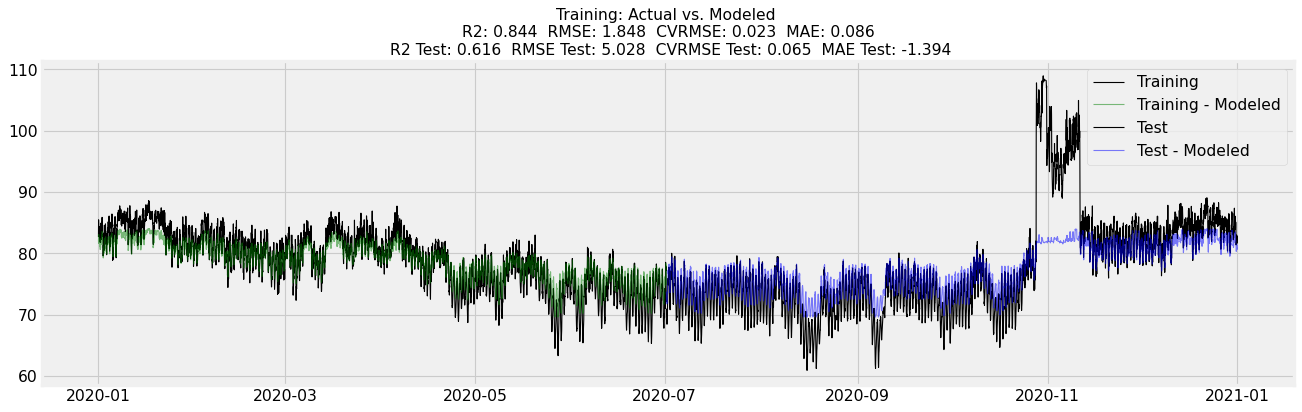

2.0277320589993906 seconds


In [107]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [78]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

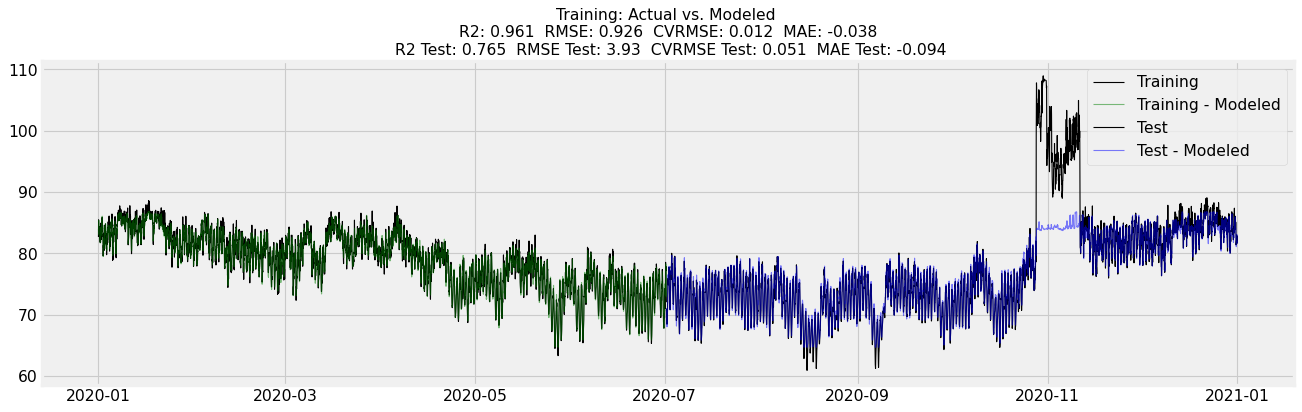

7.421656808999614 seconds


In [206]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [191]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

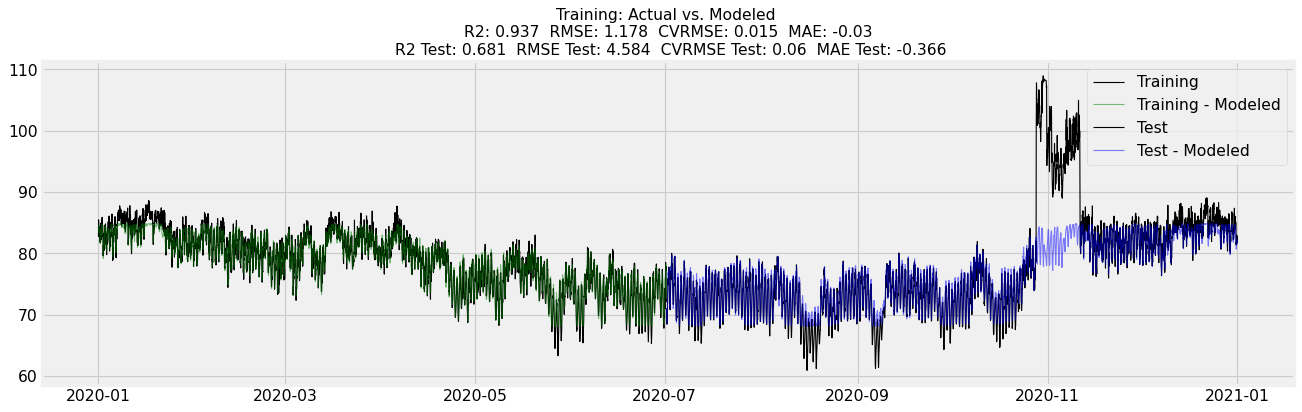

6.217831316000229 seconds


In [109]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [82]:
etr

{'random_state': 42,
 'n_estimators': 10,
 'min_samples_split': 2,
 'max_leaf_nodes': 200,
 'max_depth': 50,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.972  RMSE: 0.782  CVRMSE: 0.01  MAE: -0.009
Test: Actual vs. Modeled 
 R2: 0.713  RMSE: 4.345  CVRMSE: 0.057  MAE: -0.102


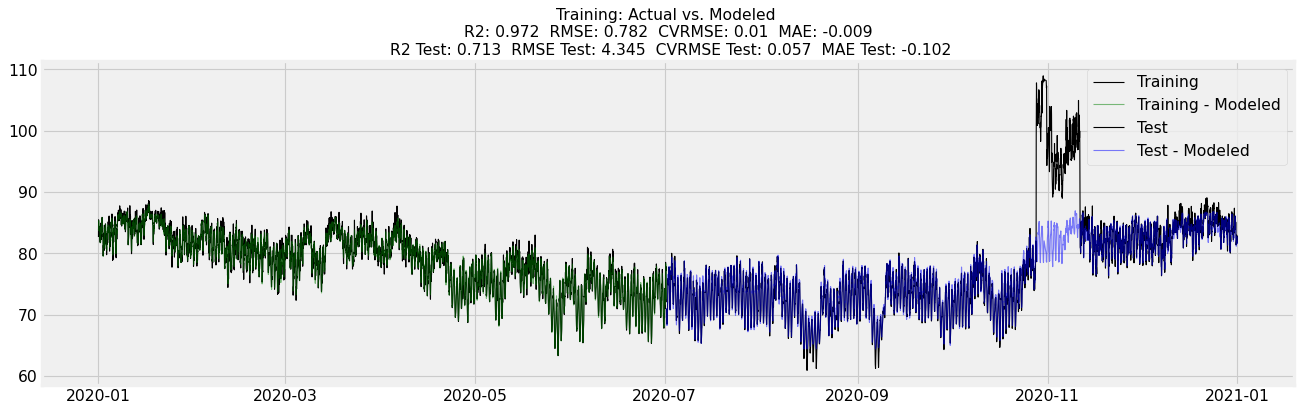

1.3529717780002102 seconds


In [110]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training: Actual vs. Modeled 
 R2: 0.974  RMSE: 0.761  CVRMSE: 0.01  MAE: -0.013
Test: Actual vs. Modeled 
 R2: 0.77  RMSE: 3.887  CVRMSE: 0.051  MAE: -0.069


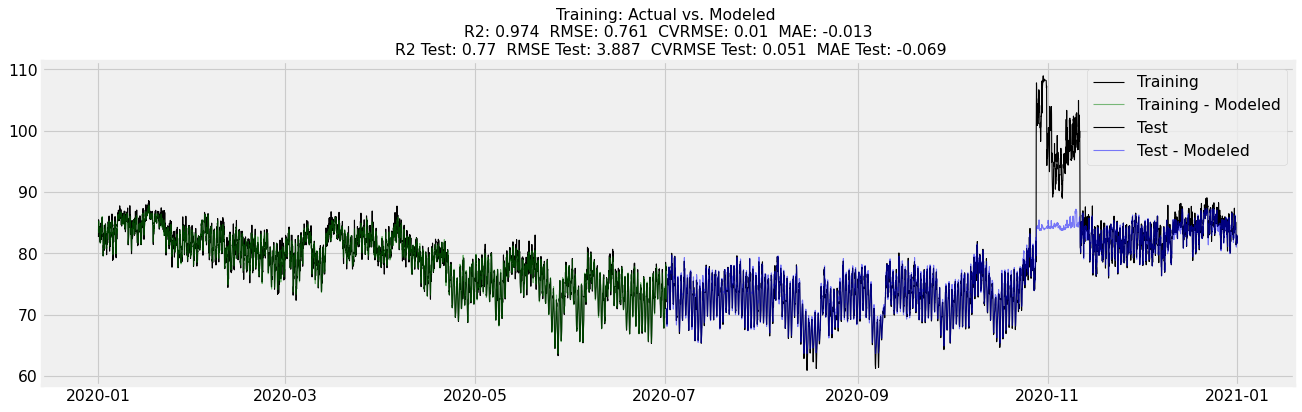

2.706242301000202 seconds


In [111]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'BJ1.AHU.AC08.Supply Air Temp'

In [207]:
tags = ['BJ1.AHU.AC08.Supply Air Temp', 'aiTIT4045']
start = '2020-01-01'
end = '2021-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [208]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:24:55: Sending API request... Chunk 1 of 1
19:24:56: Response recieved for 2 tags! (1.06)


In [209]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [210]:
data3 = clean_data(data2, 'BJ1.AHU.AC08.Supply Air Temp')

In [211]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

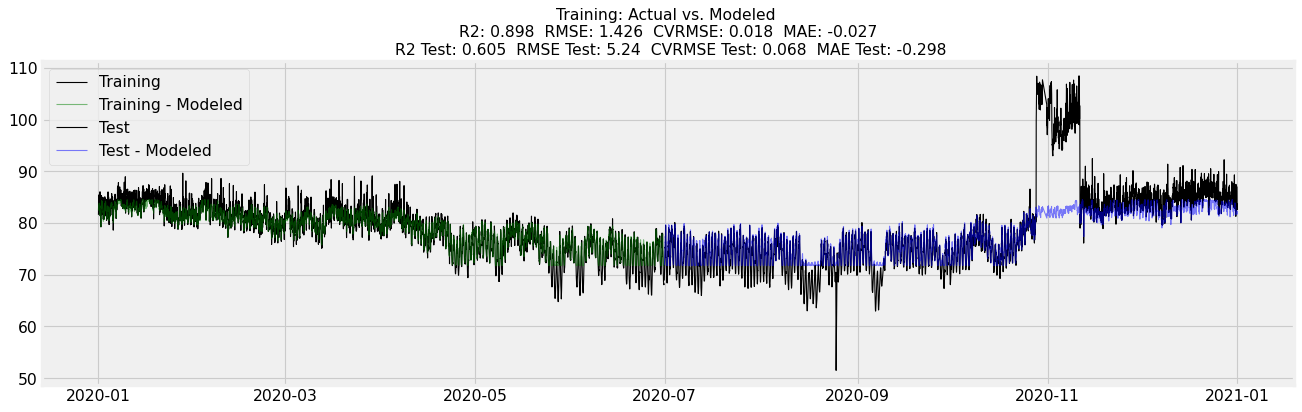

32.80260592800005 seconds


In [117]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [91]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

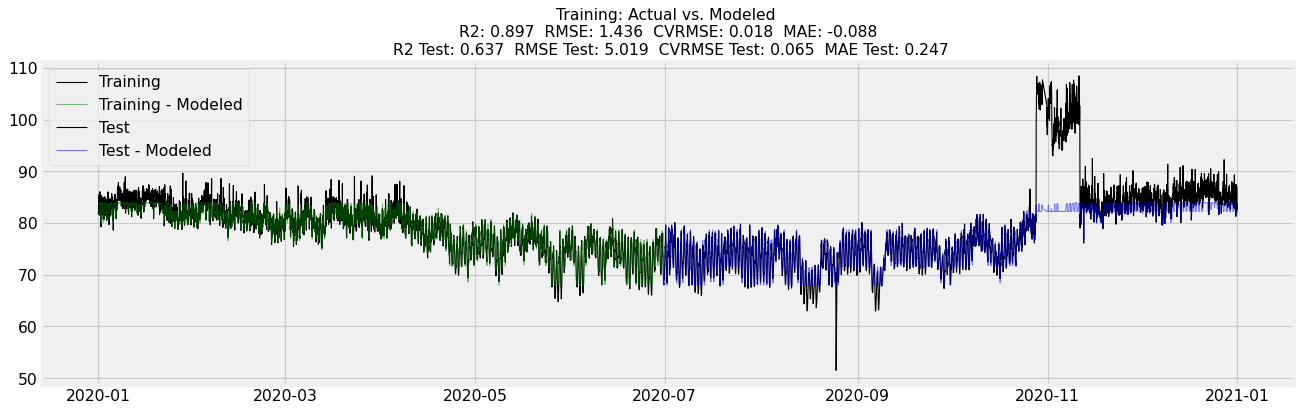

6.382677221001359 seconds


In [212]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [93]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

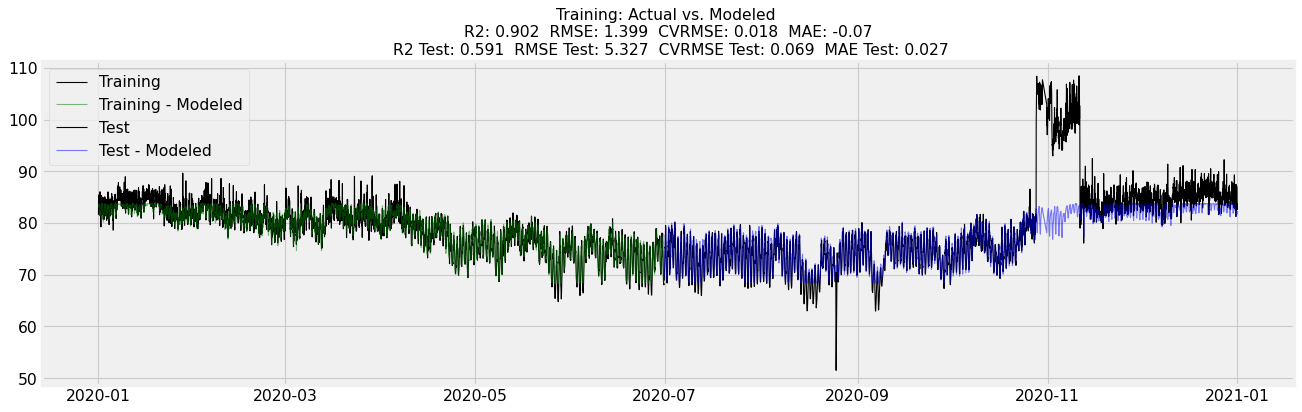

6.4931272969997735 seconds


In [119]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [95]:
etr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.954  RMSE: 0.957  CVRMSE: 0.012  MAE: -0.017
Test: Actual vs. Modeled 
 R2: 0.658  RMSE: 4.871  CVRMSE: 0.063  MAE: 0.108


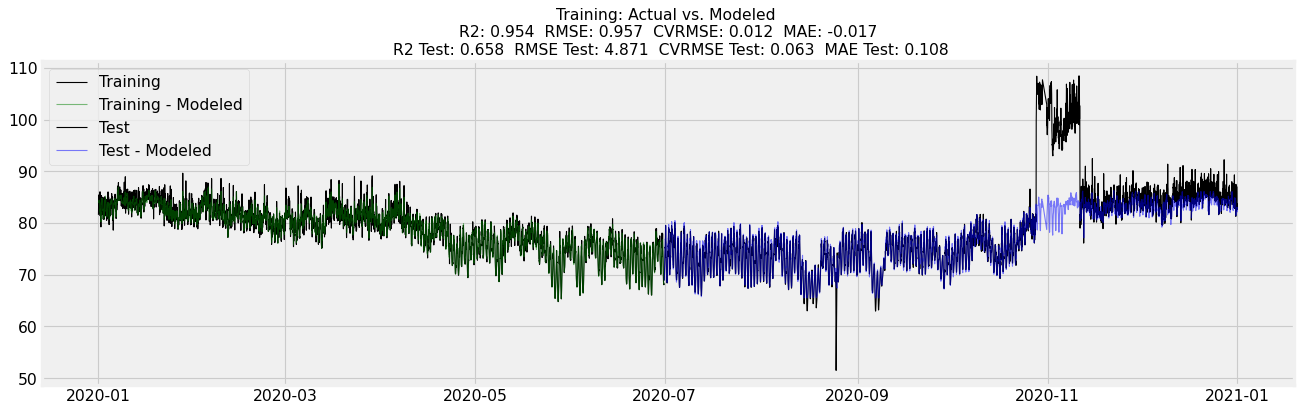

1.3218458990004365 seconds


In [120]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.957  RMSE: 0.926  CVRMSE: 0.012  MAE: -0.01
Test: Actual vs. Modeled 
 R2: 0.713  RMSE: 4.466  CVRMSE: 0.058  MAE: 0.156


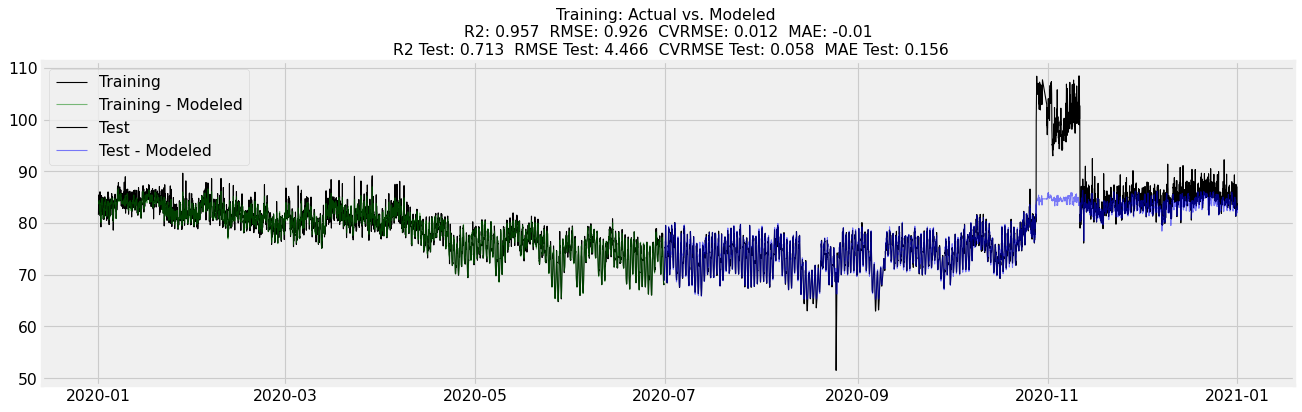

2.1605826160002835 seconds


In [121]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'ACAD.AHU.AHU01.Supply Air Temp Setpoint'

In [213]:
tags = ['ACAD.AHU.AHU01.Supply Air Temp Setpoint', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [214]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:26:17: Sending API request... Chunk 1 of 1
19:26:20: Response recieved for 2 tags! (2.12)


In [215]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [216]:
data3 = clean_data(data2, 'ACAD.AHU.AHU01.Supply Air Temp Setpoint')

In [217]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

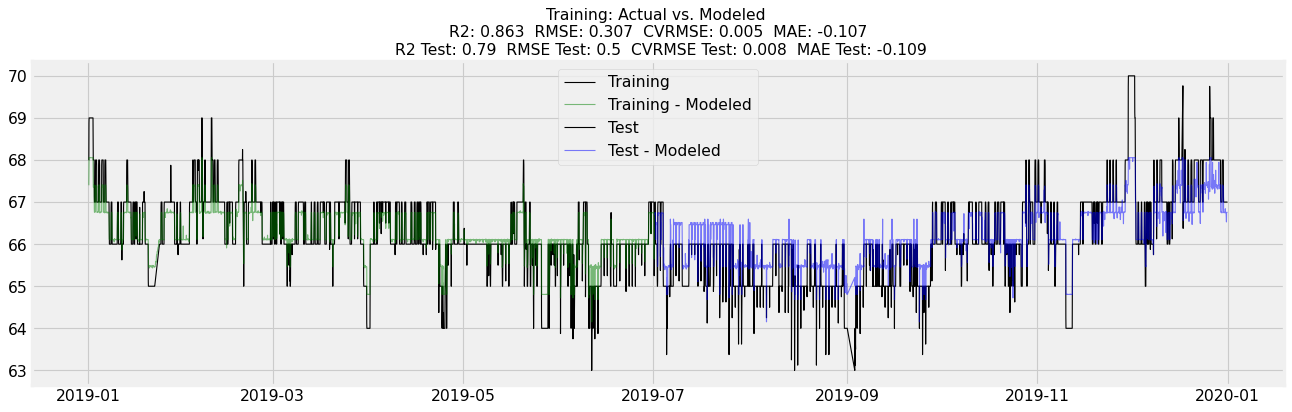

2.817028868000307 seconds


In [127]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [104]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

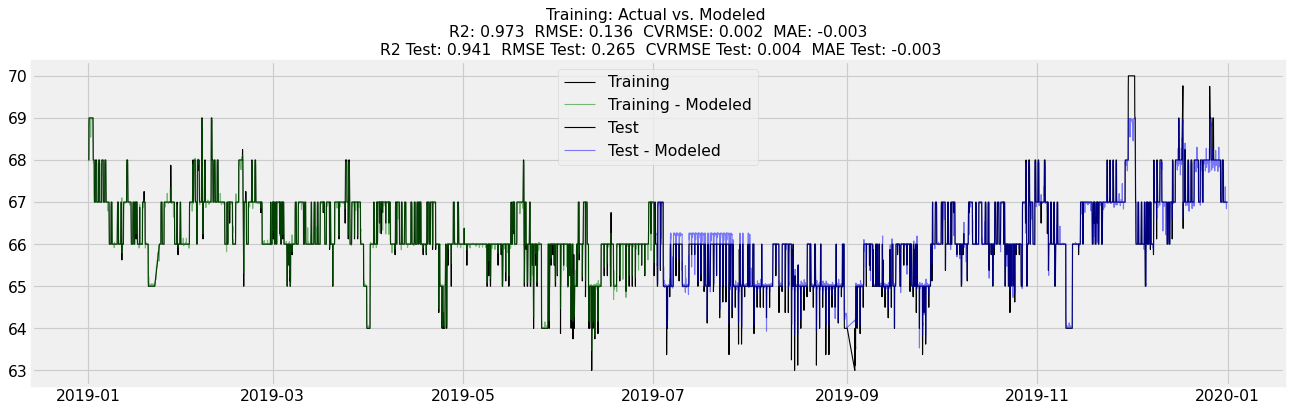

6.884427932000108 seconds


In [218]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [198]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

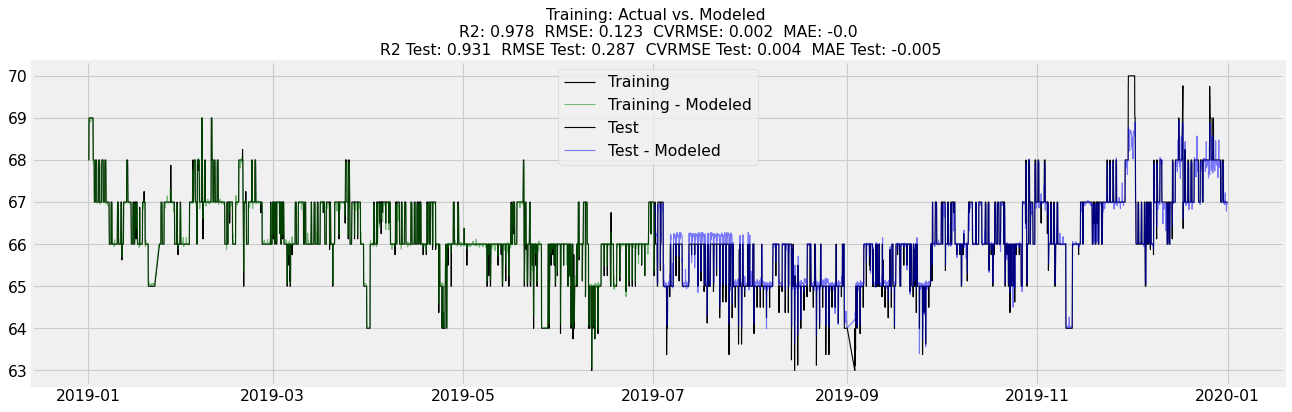

5.898267669000234 seconds


In [129]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [108]:
etr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.978  RMSE: 0.122  CVRMSE: 0.002  MAE: -0.002
Test: Actual vs. Modeled 
 R2: 0.931  RMSE: 0.286  CVRMSE: 0.004  MAE: -0.014


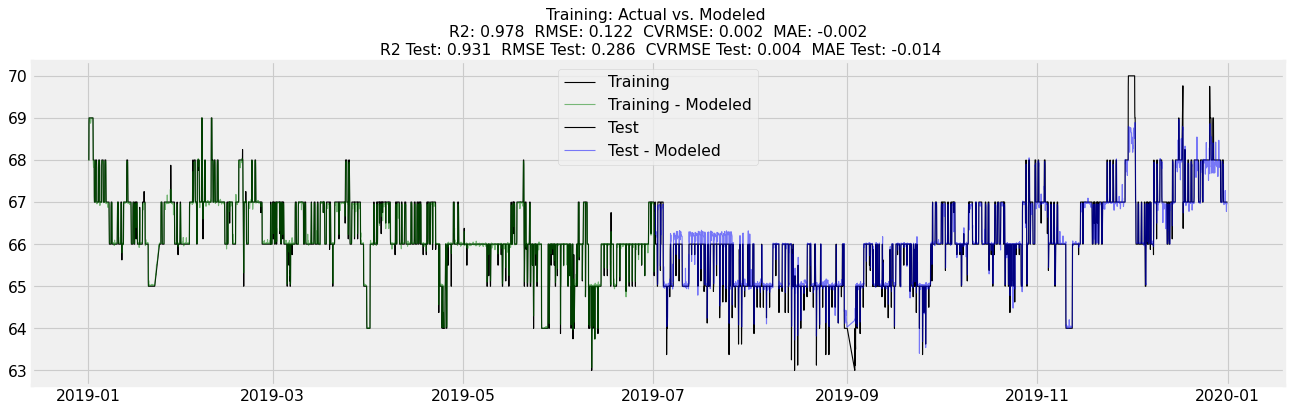

1.3612047760007044 seconds


In [130]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.979  RMSE: 0.119  CVRMSE: 0.002  MAE: -0.001
Test: Actual vs. Modeled 
 R2: 0.935  RMSE: 0.278  CVRMSE: 0.004  MAE: -0.002


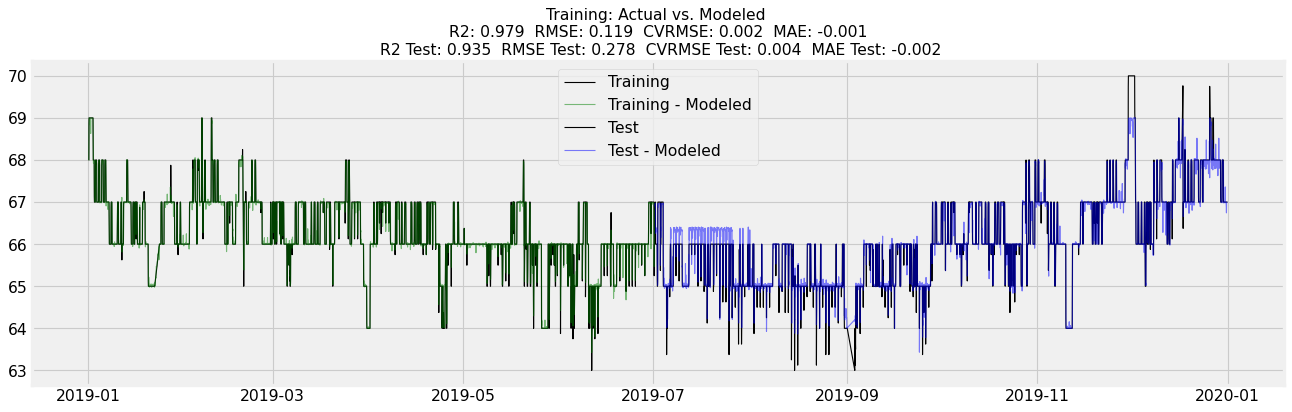

1.459787915000561 seconds


In [131]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'ACAD.AHU.AHU01.Supply Air Temp Setpoint'

In [219]:
tags = ['ACAD.AHU.AHU01.Supply Air Temp Setpoint', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [220]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:27:31: Sending API request... Chunk 1 of 1
19:27:33: Response recieved for 2 tags! (1.86)


In [221]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [222]:
data3 = clean_data(data2, 'ACAD.AHU.AHU01.Supply Air Temp Setpoint')

In [223]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

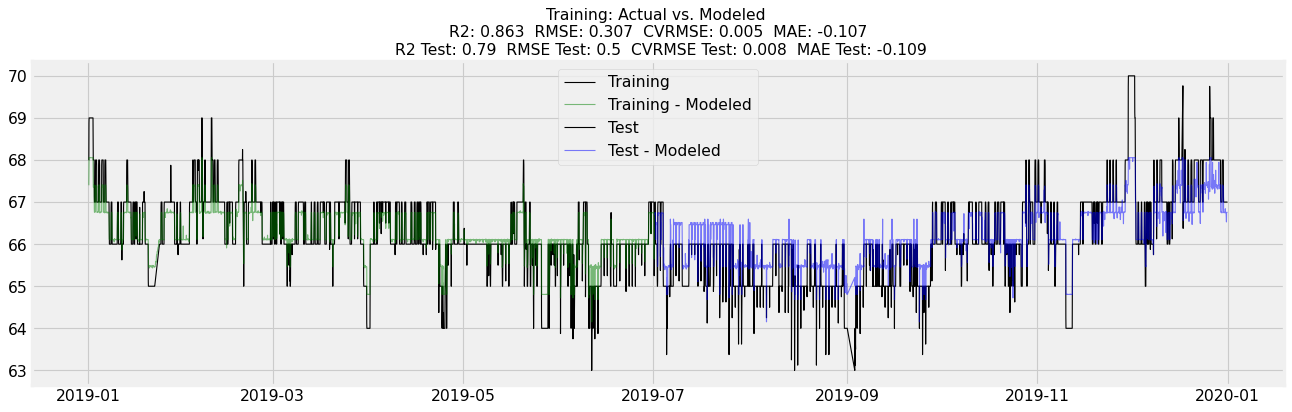

2.9798912690002908 seconds


In [137]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [117]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

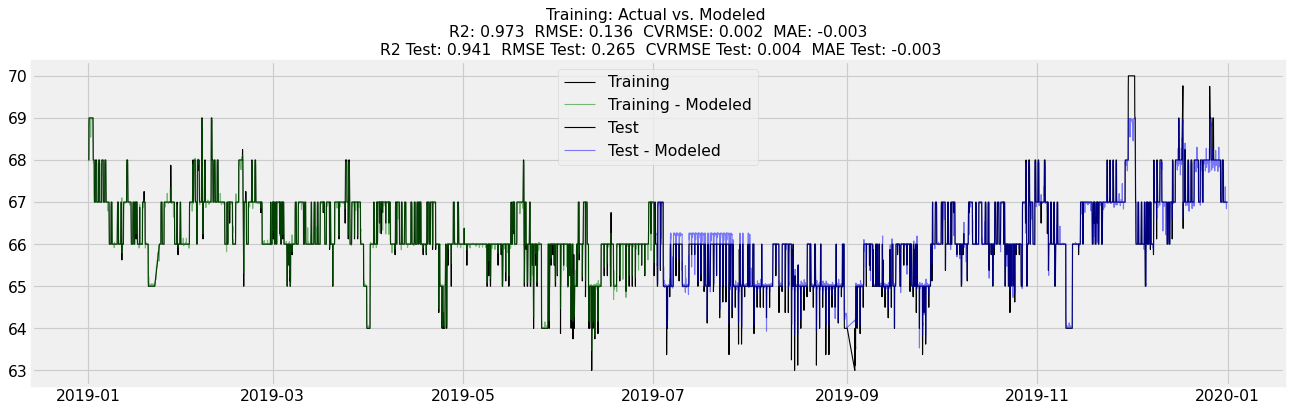

9.680917083000168 seconds


In [224]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [205]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

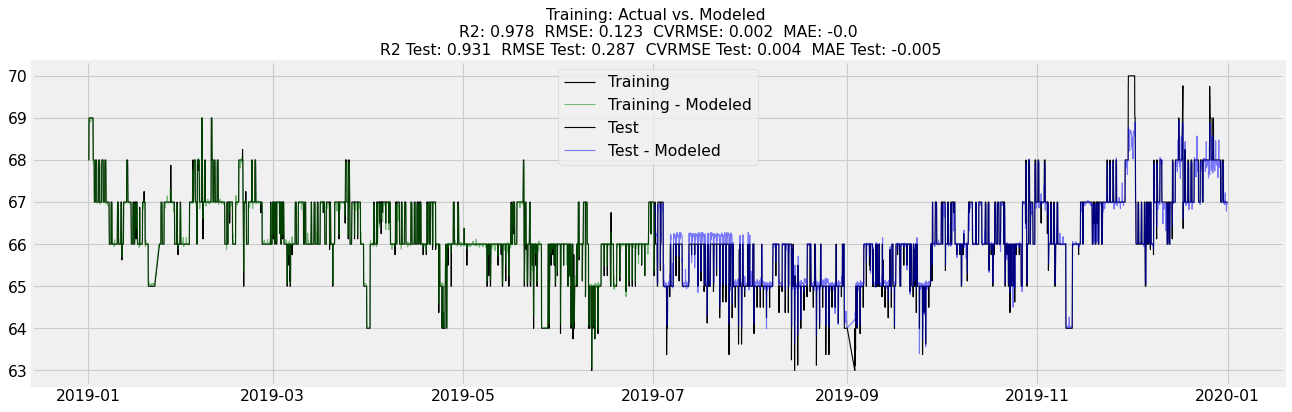

7.504922052999973 seconds


In [139]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [121]:
etr

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.978  RMSE: 0.122  CVRMSE: 0.002  MAE: -0.002
Test: Actual vs. Modeled 
 R2: 0.931  RMSE: 0.286  CVRMSE: 0.004  MAE: -0.014


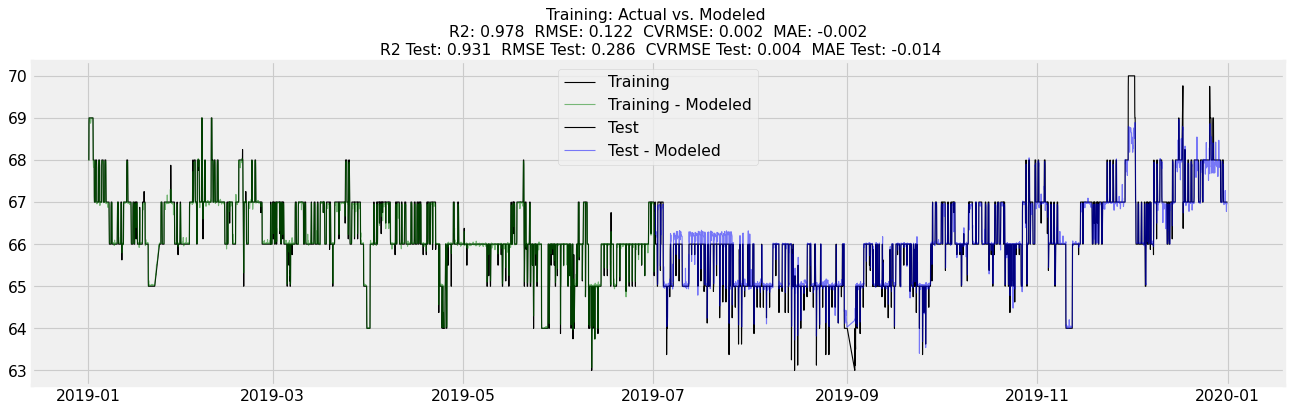

1.3643821850000677 seconds


In [140]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.979  RMSE: 0.119  CVRMSE: 0.002  MAE: -0.001
Test: Actual vs. Modeled 
 R2: 0.935  RMSE: 0.278  CVRMSE: 0.004  MAE: -0.002


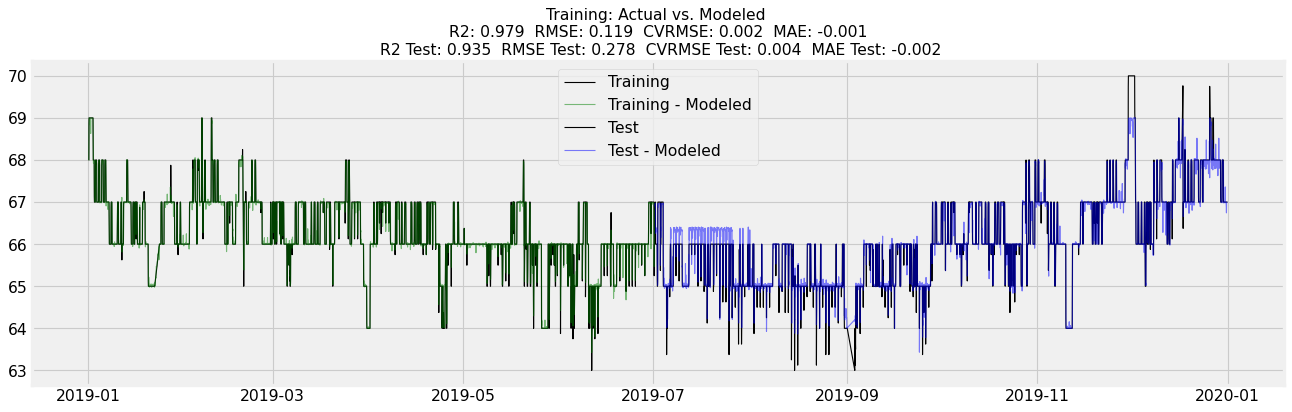

1.785212576000049 seconds


In [141]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'CHEMX.AHU.SF1N.Heating Valve Control Output'

In [225]:
tags = ['CHEMX.AHU.SF1N.Heating Valve Control Output', 'aiTIT4045']
start = '2020-01-01'
end = '2021-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [226]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:28:03: Sending API request... Chunk 1 of 1
19:28:04: Response recieved for 2 tags! (0.88)


In [227]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [228]:
data3 = clean_data(data2, 'CHEMX.AHU.SF1N.Heating Valve Control Output')

In [229]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

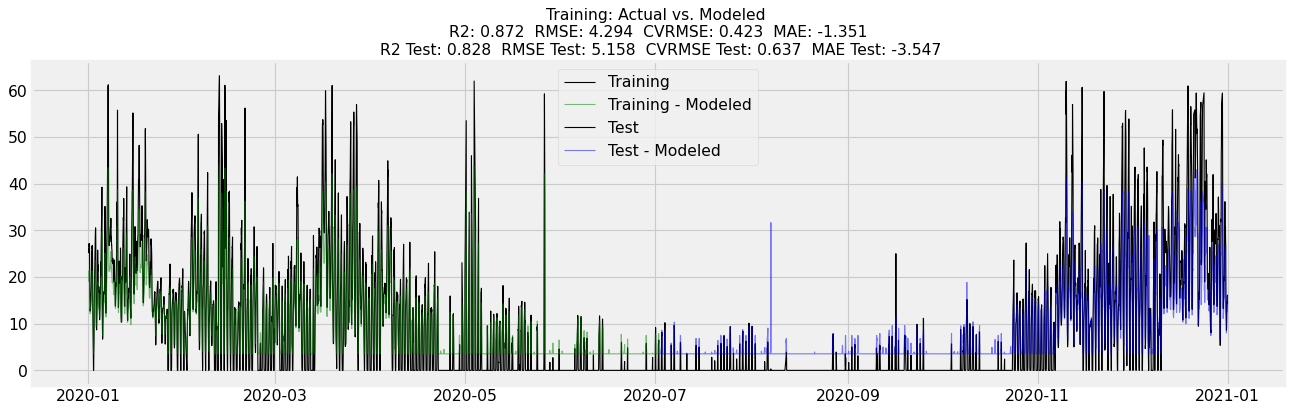

3.5798759039998913 seconds


In [147]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [130]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

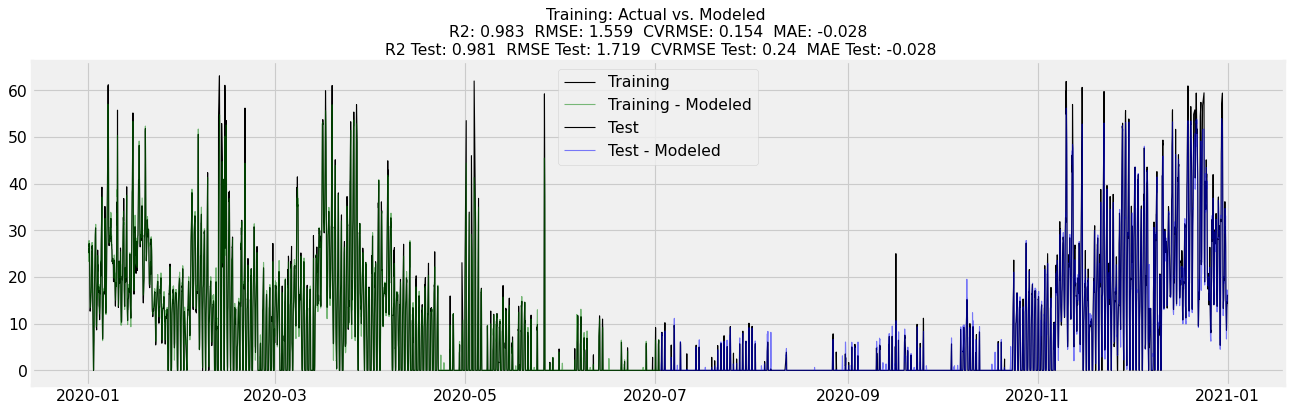

8.195302631000231 seconds


In [230]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [132]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

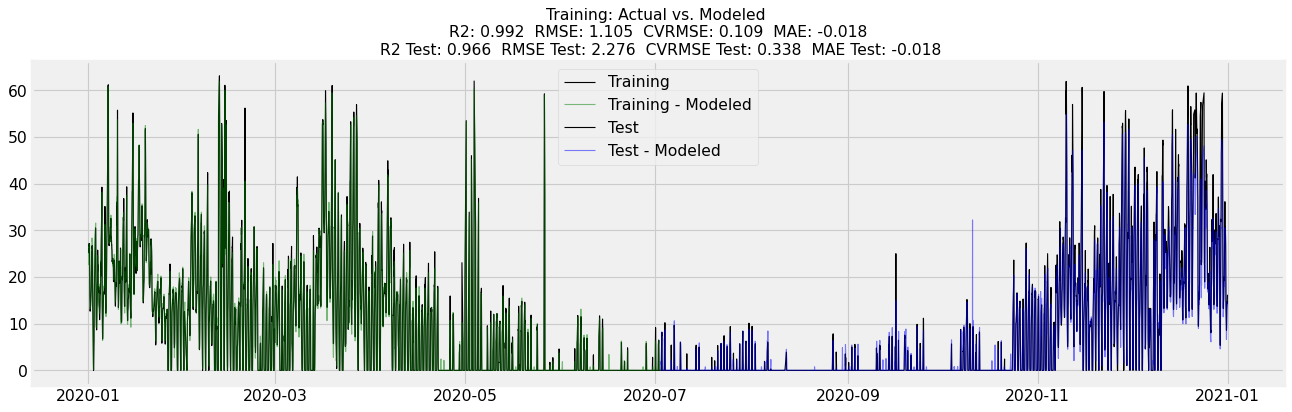

7.099144894999881 seconds


In [149]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr = create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [134]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.994  RMSE: 0.957  CVRMSE: 0.094  MAE: -0.003
Test: Actual vs. Modeled 
 R2: 0.968  RMSE: 2.232  CVRMSE: 0.332  MAE: -0.003


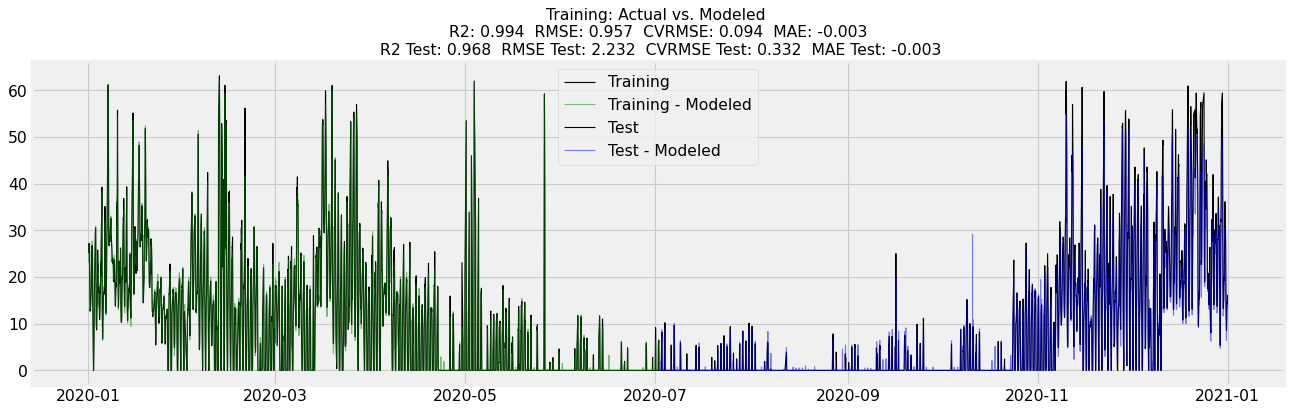

1.3943070820005232 seconds


In [150]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.988  RMSE: 1.314  CVRMSE: 0.13  MAE: -0.0
Test: Actual vs. Modeled 
 R2: 0.981  RMSE: 1.729  CVRMSE: 0.243  MAE: -0.0


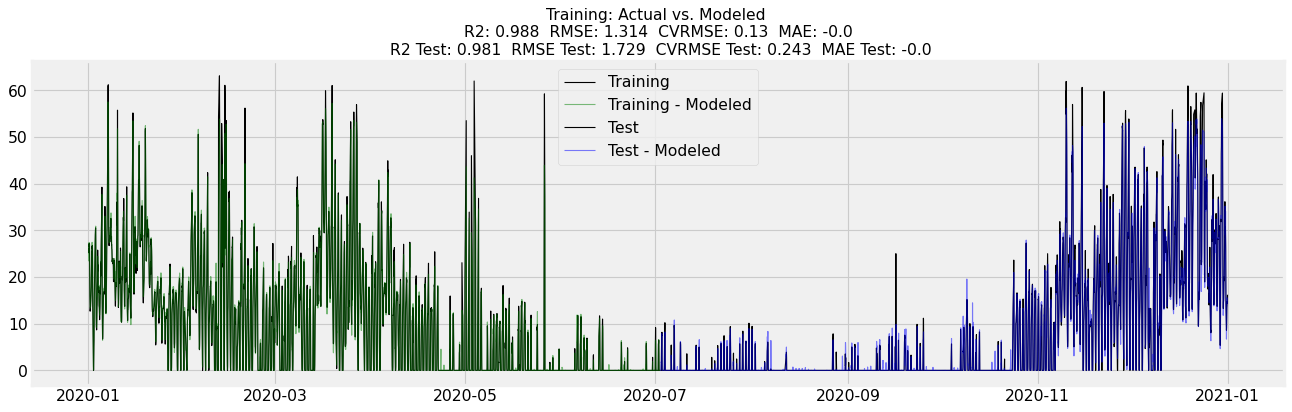

1.8333768570000757 seconds


In [151]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")


## 'CHEMX.AHU.SF1S.Heating Valve Control Output'

In [231]:
tags = [ 'CHEMX.AHU.SF1S.Heating Valve Control Output', 'aiTIT4045']
start = '2019-01-01'
end = '2020-01-01'
interval = '1h'
calculation = 'summary'
summary_type = 'average'

In [232]:
data = pi.get_stream_by_point(tags=tags, start=start, end=end, interval=interval, calculation=calculation, _summary_type=summary_type)
#data.head()

19:28:39: Sending API request... Chunk 1 of 1
19:28:41: Response recieved for 2 tags! (2.03)


In [233]:
data2 = create_standard_multivariable_df(data)
#data2.head()

In [234]:
data3 = clean_data(data2,  'CHEMX.AHU.SF1S.Heating Valve Control Output')

In [235]:
y = data3.iloc[:,0]
X = data3.iloc[:,1:]

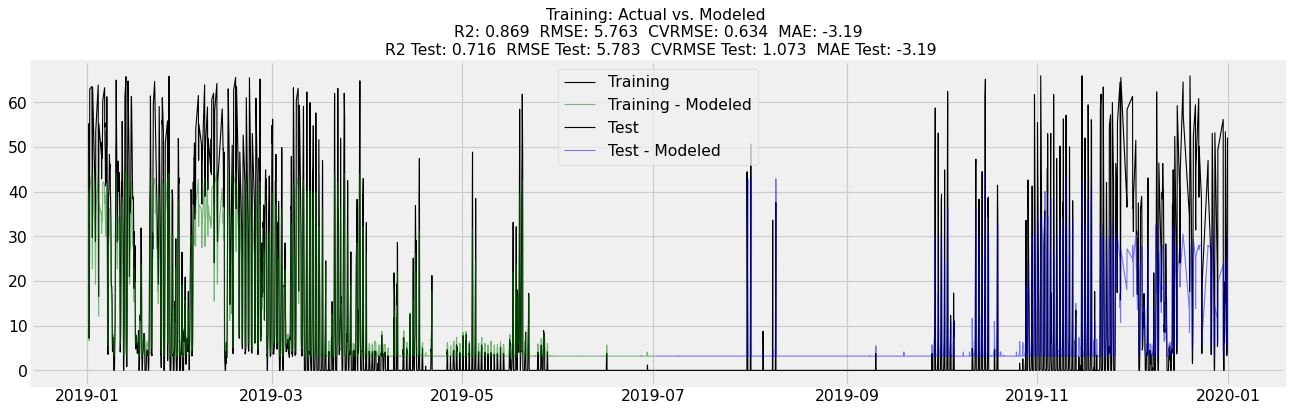

3.066745062999871 seconds


In [157]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#gbr = create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_gbr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_gbr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [143]:
gbr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'max_leaf_nodes': 200,
 'max_depth': 10,
 'loss': 'ls',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

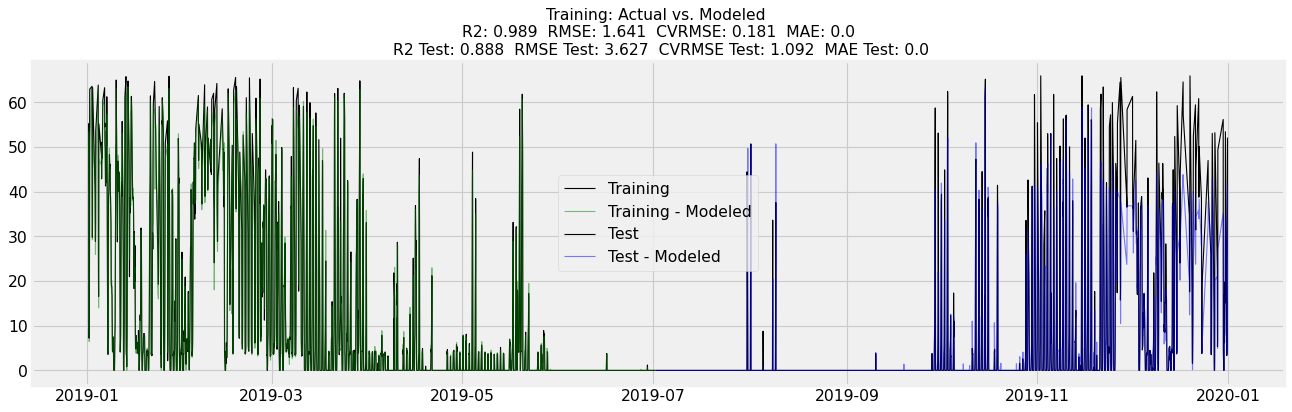

92.8414825609998 seconds


In [237]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#rfr = create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_rfr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_rfr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


In [146]:
rfr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 10,
 'max_depth': 50,
 'criterion': 'absolute_error'}

In [159]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

#etr= create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)
time = timeit.timeit("create_etr_model_hrs(data3, X, y, mod_inputs=mod_inputs)", "from __main__ import create_etr_model_hrs, data3, X, y, mod_inputs", number =1 )
print(f"{time} seconds")


KeyboardInterrupt: 

In [148]:
etr

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'squared_error'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.994  RMSE: 1.211  CVRMSE: 0.133  MAE: -0.0
Test: Actual vs. Modeled 
 R2: 0.897  RMSE: 3.481  CVRMSE: 1.037  MAE: -0.0


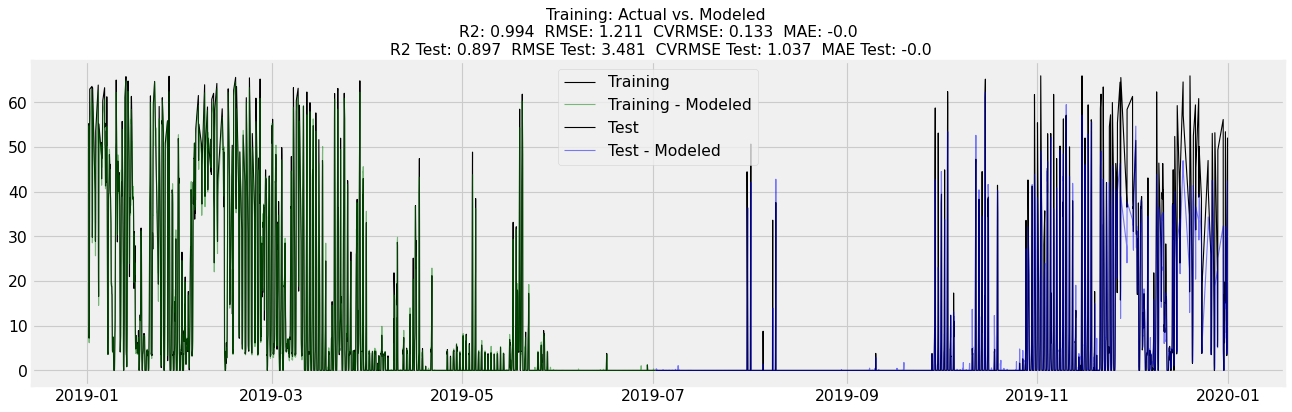

1.1647288129997833 seconds


In [160]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_et = ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#et = create_model(data2, X, y, mod_et, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_et, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_et, mod_inputs", number =1 )
print(f"{time} seconds")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training: Actual vs. Modeled 
 R2: 0.992  RMSE: 1.441  CVRMSE: 0.159  MAE: -0.0
Test: Actual vs. Modeled 
 R2: 0.881  RMSE: 3.746  CVRMSE: 1.113  MAE: -0.0


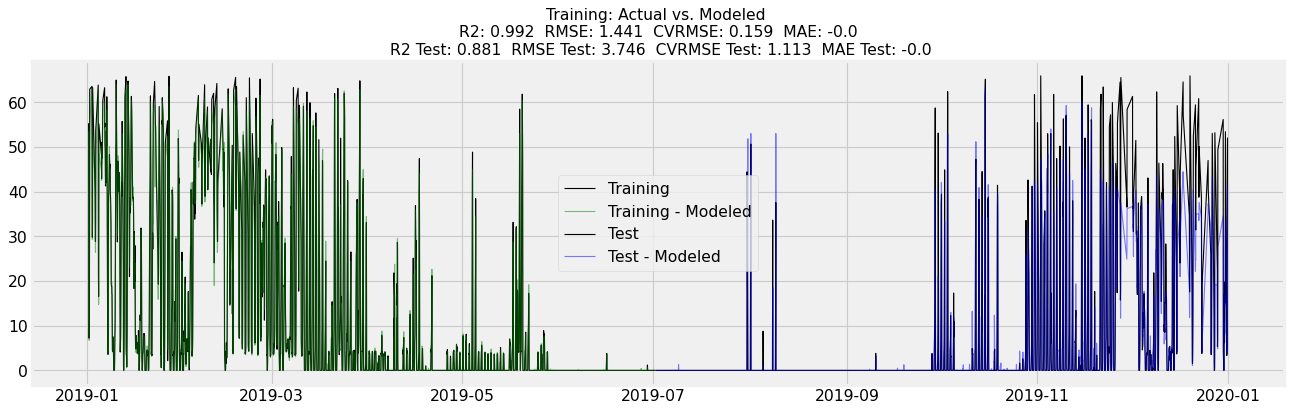

1.5063412830004381 seconds


In [161]:
#%%time
mod_inputs = {'training_percent':0.5,
              'random_seed':42}

mod_rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=mod_inputs['random_seed'],verbose = 1)

#rf = create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)
time = timeit.timeit("create_model(data3, X, y, mod_rf, mod_inputs=mod_inputs)", "from __main__ import create_model, data3, X, y, mod_rf, mod_inputs", number =1 )
print(f"{time} seconds")
